In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45311")
client

<Client: 'tcp://127.0.0.1:45311' processes=8 threads=40, memory=157.35 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from xhistogram.xarray import histogram as xhist
from xgcm.grid import Grid
import xrft
import s3fs
import gsw

import rioxarray

import glob

import gcm_filters

import seaborn as sns

import os.path as op

from scipy.interpolate import griddata, interpn

# from xeofs.models import EOF
from pydmd import DMD, BOPDMD, MrDMD
from pydmd.mrcosts import mrCOSTS
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_eigs, plot_summary

from matplotlib import ticker
import matplotlib.colors as clr
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
grav = 9.807
meth = 'linear'
sdir = '/tank/spectre/tuchida/SWOT/'
ddir = '/tank/spectre/tuchida/DMD/'

In [5]:
ds = xr.open_dataset(op.join(sdir, 
'SWOT_calval_L3_LR_ssha_med_campaign/SWOT_L3_LR_SSHA_543_003_20230605T125748_20230605T134853_v2.0.1_denoised_v3.0.nc')
                    )  # 64-th time step
# ds.longitude[ds.longitude>180] -= 360
ds3 = ds.where((ds.latitude>36.2) & (ds.latitude<44),
               drop=True)
ds3 = ds3.where((ds3.longitude>0) & (ds3.longitude<6.5),
                drop=True)
ds.close()
ds = xr.open_dataset(op.join(sdir, 
'SWOT_calval_L3_LR_ssha_med_campaign/SWOT_L3_LR_SSHA_544_003_20230606T124826_20230606T133931_v2.0.1_denoised_v3.0.nc')
                    )
# ds.longitude[ds.longitude>180] -= 360
ds36 = ds.where((ds.latitude>36.2) & (ds.latitude<44)
                & (ds.longitude>0) & (ds.longitude<6.5),
                drop=True)
ds.close()
ds = xr.open_dataset(op.join(sdir, 
'SWOT_calval_L3_LR_ssha_med_campaign/SWOT_L3_LR_SSHA_545_003_20230607T123904_20230607T133009_v2.0.1_denoised_v3.0.nc')
                    )
# ds.longitude[ds.longitude>180] -= 360
ds37 = ds.where((ds.latitude>36.2) & (ds.latitude<44)
                & (ds.longitude>0) & (ds.longitude<6.5),
               drop=True)
ds.close()
ds = xr.open_dataset(op.join(sdir, 
'SWOT_calval_L3_LR_ssha_med_campaign/SWOT_L3_LR_SSHA_546_003_20230608T122942_20230608T132047_v2.0.1_denoised_v3.0.nc')
                    )
# ds.longitude[ds.longitude>180] -= 360
ds38 = ds.where((ds.latitude>36.2) & (ds.latitude<44)
                & (ds.longitude>0) & (ds.longitude<6.5),
               drop=True)
ds.close()
ds = xr.open_dataset(op.join(sdir, 
'SWOT_calval_L3_LR_ssha_med_campaign/SWOT_L3_LR_SSHA_544_016_20230606T235240_20230607T004344_v2.0.1_denoised_v3.0.nc')
                    )
ds16 = ds.where((ds.latitude>36.2) & (ds.latitude<43),
                drop=True)
ds16 = ds16.where((ds16.longitude>0) & (ds16.longitude<6.5),
                  drop=True)
ds16

<xarray.Dataset> Size: 2MB
Dimensions:                        (num_lines: 404, num_pixels: 69)
Coordinates:
    latitude                       (num_lines, num_pixels) float64 223kB 43.2...
    longitude                      (num_lines, num_pixels) float64 223kB 1.75...
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    cycle_number                   (num_lines, num_pixels) float32 112kB nan ...
    duacs_editing_flag             (num_lines, num_pixels) float64 223kB nan ...
    duacs_ssha_karin_2_calibrated  (num_lines, num_pixels) float64 223kB nan ...
    pass_number                    (num_lines, num_pixels) float32 112kB nan ...
    ssha_karin_2_filtered_v3       (num_lines, num_pixels) float64 223kB nan ...
    time                           (num_lines, num_pixels) datetime64[ns] 223kB ...
    ugos_v3                        (num_lines, num_pixels) float64 223kB nan ...
    ugosa_v3                       (num_lines, num_pixels) float64 223kB nan ...
    vgos_v3                        (num_lines, num_pixels) float64 223kB nan ...
    vgosa_v3                       (num_lines, num_pixels) float64 223kB nan ...

In [9]:
print(ds3.latitude.max(),ds3.latitude.min(),
      ds3.longitude.max(),ds3.longitude.min()
     )
print(ds16.latitude.max(),ds16.latitude.min(),
      ds16.longitude.max(),ds16.longitude.min())

<xarray.DataArray 'latitude' ()>
array(44.290275)
Attributes:
    comment:        Latitude of measurement [-80,80]. Positive latitude is No...
    long_name:      latitude (positive N, negative S)
    standard_name:  latitude
    units:          degrees_north <xarray.DataArray 'latitude' ()>
array(35.944799)
Attributes:
    comment:        Latitude of measurement [-80,80]. Positive latitude is No...
    long_name:      latitude (positive N, negative S)
    standard_name:  latitude
    units:          degrees_north <xarray.DataArray 'longitude' ()>
array(6.577733)
Attributes:
    comment:        Longitude of measurement. East longitude relative to Gree...
    long_name:      longitude (degrees East)
    standard_name:  longitude
    units:          degrees_east <xarray.DataArray 'longitude' ()>
array(2.532093)
Attributes:
    comment:        Longitude of measurement. East longitude relative to Gree...
    long_name:      longitude (degrees East)
    standard_name:  longitude
    units: 

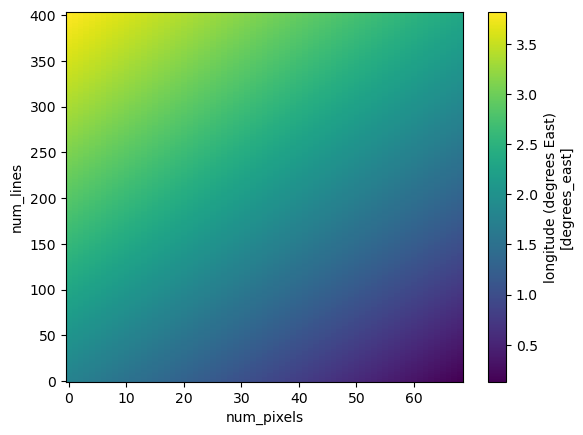

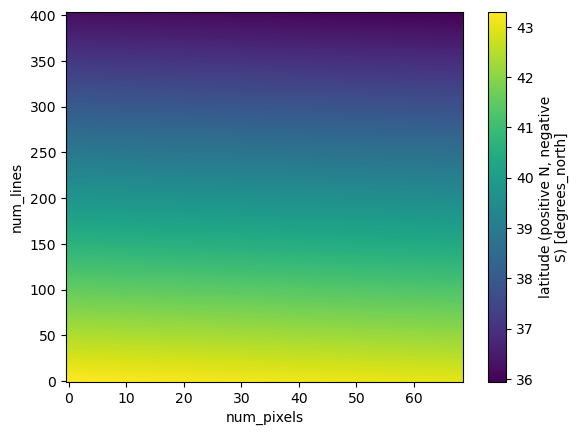

In [50]:
ds16.longitude.plot()
plt.show()
ds16.latitude.plot()
plt.show()

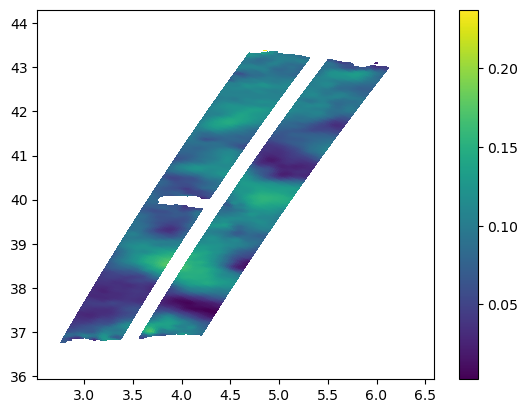

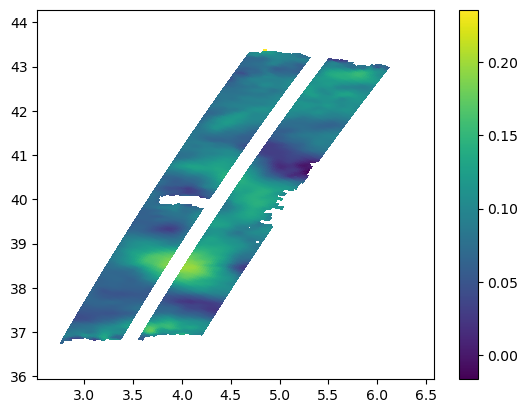

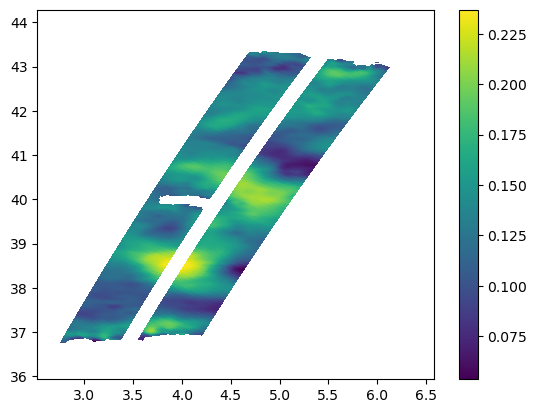

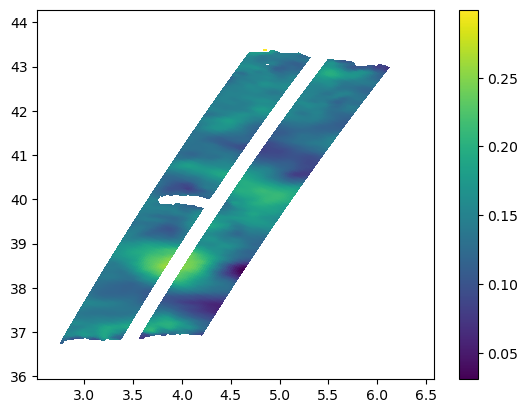

In [15]:
fig, ax = plt.subplots()
im = ax.pcolor(ds3.longitude, ds3.latitude,
          ds3.ssha_karin_2_filtered_v3, 
          rasterized=True
         )
fig.colorbar(im)
plt.show()
# ax.pcolor(ds16.longitude, ds16.latitude,
#           ds16.ssha_karin_2_filtered_v3, 
#           rasterized=True
#          )
# ax.set_xlim([0,6.5])
fig, ax = plt.subplots()
im = ax.pcolor(ds36.longitude, ds36.latitude,
          ds36.ssha_karin_2_filtered_v3, 
          rasterized=True
         )
fig.colorbar(im)
plt.show()
fig, ax = plt.subplots()
im = ax.pcolor(ds37.longitude, ds37.latitude,
          ds37.ssha_karin_2_filtered_v3, 
          rasterized=True
         )
fig.colorbar(im)
plt.show()
fig, ax = plt.subplots()
im = ax.pcolor(ds38.longitude, ds38.latitude,
          ds38.ssha_karin_2_filtered_v3, 
          rasterized=True
         )
fig.colorbar(im)
plt.show()

In [5]:
pass3names = [
"SWOT_L3_LR_SSHA_474_003_20230328T234417_20230329T003522_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_475_003_20230329T233455_20230330T002600_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_476_003_20230330T232532_20230331T001637_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_478_003_20230401T230647_20230401T235752_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_479_003_20230402T225725_20230402T234830_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_480_003_20230403T224803_20230403T233908_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_481_003_20230404T223841_20230404T232946_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_482_003_20230405T222918_20230405T232023_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_483_003_20230406T221957_20230406T231102_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_484_003_20230407T221035_20230407T230140_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_485_003_20230408T220113_20230408T225218_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_486_003_20230409T215151_20230409T224256_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_487_003_20230410T214229_20230410T223334_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_488_003_20230411T213307_20230411T222412_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_489_003_20230412T212345_20230412T221450_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_490_003_20230413T211423_20230413T220528_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_491_003_20230414T210501_20230414T215606_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_492_003_20230415T205539_20230415T214644_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_493_003_20230416T204617_20230416T213722_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_494_003_20230417T203655_20230417T212800_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_495_003_20230418T202733_20230418T211838_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_496_003_20230419T201811_20230419T210916_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_497_003_20230420T200848_20230420T205954_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_499_003_20230422T195004_20230422T204109_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_500_003_20230423T194042_20230423T203147_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_501_003_20230424T193120_20230424T202225_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_502_003_20230425T192158_20230425T201303_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_503_003_20230426T191236_20230426T200341_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_504_003_20230427T190314_20230427T195419_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_505_003_20230428T185352_20230428T194457_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_506_003_20230429T184429_20230429T193535_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_507_003_20230430T183507_20230430T192612_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_508_003_20230501T182545_20230501T191650_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_509_003_20230502T181623_20230502T190728_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_510_003_20230503T180700_20230503T185805_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_511_003_20230504T175738_20230504T184843_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_512_003_20230505T174816_20230505T183921_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_513_003_20230506T173853_20230506T182959_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_514_003_20230507T172931_20230507T182036_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_515_003_20230508T172009_20230508T181114_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_516_003_20230509T171047_20230509T180152_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_517_003_20230510T170125_20230510T175230_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_518_003_20230511T165202_20230511T174308_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_519_003_20230512T164240_20230512T173345_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_520_003_20230513T163318_20230513T172423_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_521_003_20230514T162355_20230514T171500_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_522_003_20230515T161433_20230515T170538_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_523_003_20230516T160511_20230516T165616_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_524_003_20230517T155548_20230517T164653_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_525_003_20230518T154626_20230518T163731_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_529_003_20230522T150858_20230522T160003_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_530_003_20230523T145936_20230523T155041_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_531_003_20230524T145014_20230524T154119_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_532_003_20230525T144052_20230525T153157_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_533_003_20230526T143130_20230526T152235_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_534_003_20230527T142208_20230527T151313_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_535_003_20230528T141245_20230528T150351_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_536_003_20230529T140323_20230529T145428_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_537_003_20230530T135401_20230530T144506_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_538_003_20230531T134439_20230531T143544_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_539_003_20230601T133516_20230601T142622_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_540_003_20230602T132554_20230602T141659_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_541_003_20230603T131632_20230603T140737_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_542_003_20230604T130710_20230604T135815_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_543_003_20230605T125748_20230605T134853_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_544_003_20230606T124826_20230606T133931_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_545_003_20230607T123904_20230607T133009_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_546_003_20230608T122942_20230608T132047_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_547_003_20230609T122020_20230609T131125_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_548_003_20230610T121057_20230610T130202_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_549_003_20230611T120135_20230611T125240_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_550_003_20230612T115213_20230612T124318_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_551_003_20230613T114250_20230613T123355_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_552_003_20230614T113328_20230614T122433_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_553_003_20230615T112406_20230615T121511_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_554_003_20230616T111443_20230616T120548_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_555_003_20230617T110521_20230617T115626_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_556_003_20230618T105559_20230618T114705_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_557_003_20230619T104638_20230619T113743_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_558_003_20230620T103716_20230620T112821_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_559_003_20230621T102754_20230621T111859_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_560_003_20230622T101832_20230622T110937_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_561_003_20230623T100910_20230623T110015_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_562_003_20230624T095948_20230624T105053_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_563_003_20230625T095026_20230625T104131_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_564_003_20230626T094104_20230626T103209_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_565_003_20230627T093141_20230627T102246_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_567_003_20230629T091257_20230629T100402_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_568_003_20230630T090335_20230630T095440_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_569_003_20230701T085413_20230701T094518_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_570_003_20230702T084451_20230702T093556_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_571_003_20230703T083529_20230703T092634_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_573_003_20230705T081645_20230705T090750_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_574_003_20230706T080723_20230706T085828_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_575_003_20230707T075801_20230707T084906_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_576_003_20230708T074839_20230708T083943_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_577_003_20230709T073917_20230709T083021_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_578_003_20230710T072954_20230710T082059_v2.0.1_denoised_v3.0.nc"
]

len(pass3names)

98

In [6]:
for cc in pass3names:

    fname = (op.join(sdir,'SWOT_calval_L3_LR_ssha_med_campaign/')
             + cc)
    ds = xr.open_dataset(fname)
    # ds.longitude[ds.longitude>180] -= 360
    ds3 = ds.where((ds.latitude>36.2) & (ds.latitude<44),
                   drop=True)
    ds3 = ds3.where((ds3.longitude>0) & (ds3.longitude<6.5),
                    drop=True)
    
    if cc == pass3names[0]:
        dsMS = ds3.ssha_karin_2_filtered_v3
        dsMS.coords["time"] = ds3.time
    else:
        tmp = ds3.ssha_karin_2_filtered_v3
        tmp.coords["time"] = ds3.time
        dsMS = xr.concat([dsMS, tmp
                         ], 'calval')
    ds.close()

print(dsMS)
dsMS.to_dataset(name="ssha_v3").to_zarr(op.join(sdir,
                     '01-day-repeat/MedSea/Pass%03d.zarr' 
                    % 3), mode='w')
dsMS.close()

<xarray.DataArray 'ssha_karin_2_filtered_v3' (calval: 98, num_lines: 461,
                                              num_pixels: 69)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan,

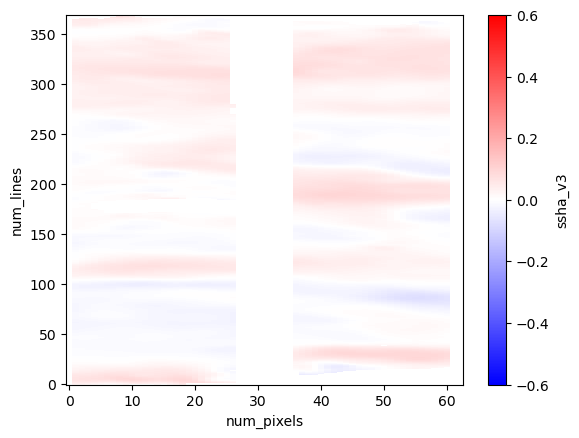

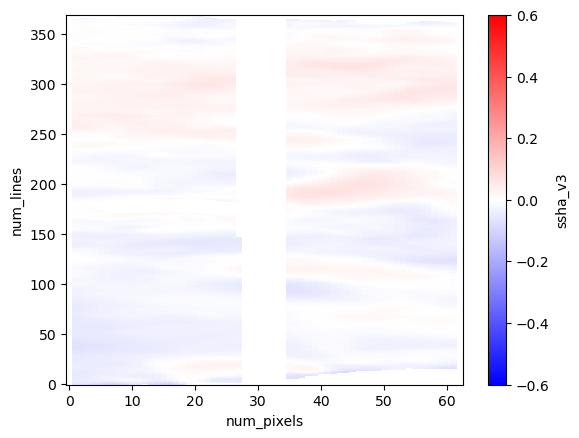

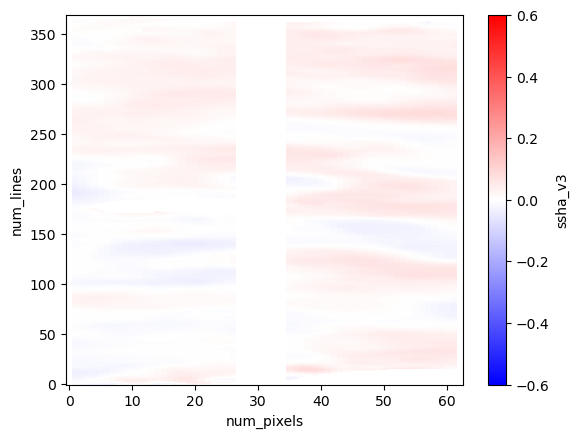

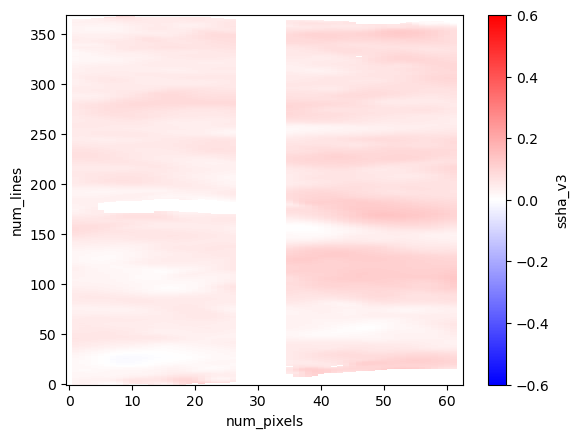

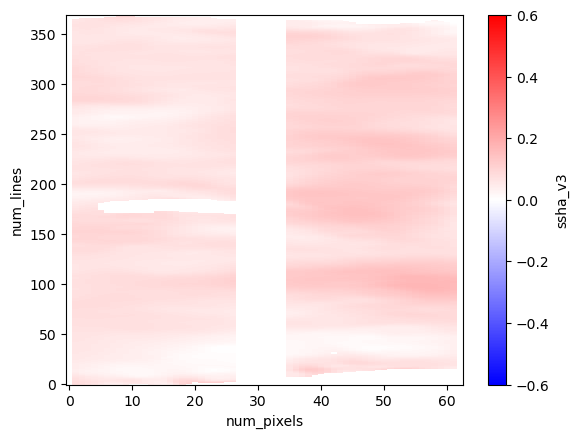

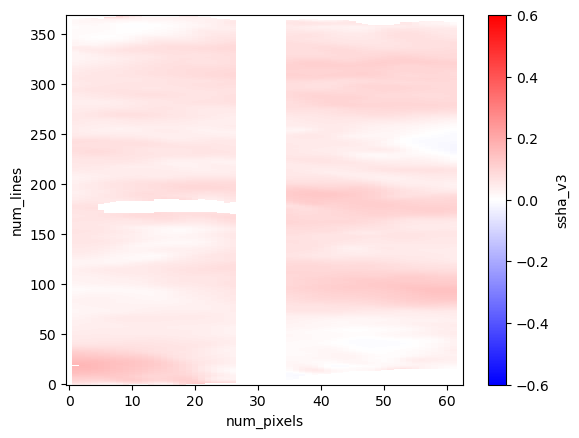

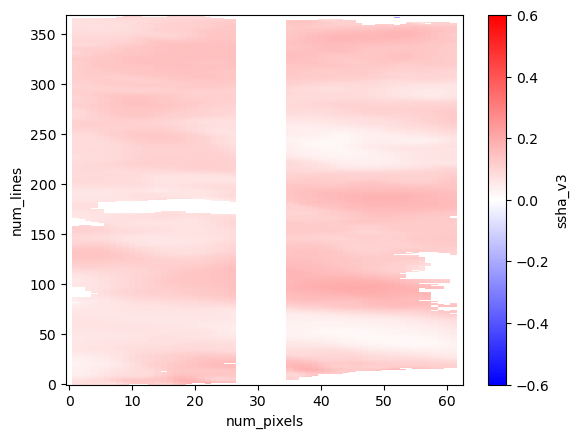

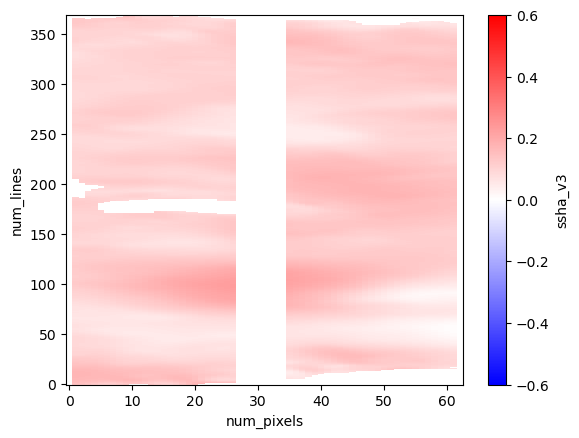

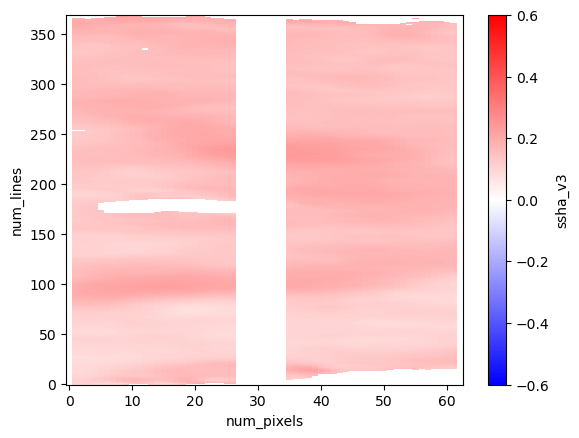

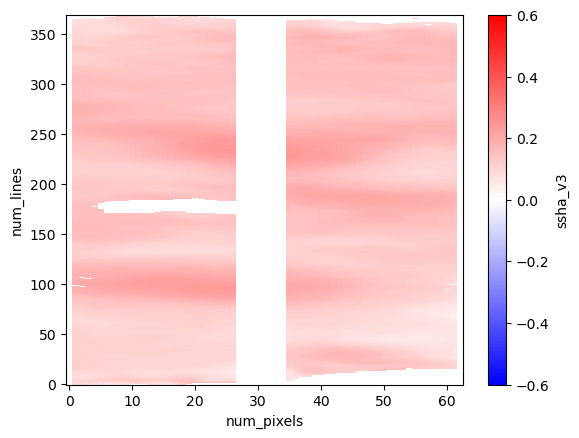

In [7]:
ds3 = xr.open_zarr(op.join(sdir,
                     '01-day-repeat/MedSea/Pass%03d.zarr' 
                     % 3))
for cc in range(0,len(ds3.calval),10):
    ds3.ssha_v3.isel(calval=cc,
                     num_lines=slice(40,410),
                      num_pixels=slice(3,-3)
                    ).plot(rasterized=True, 
                           vmax=.6, vmin=-.6, cmap="bwr")
    plt.show()

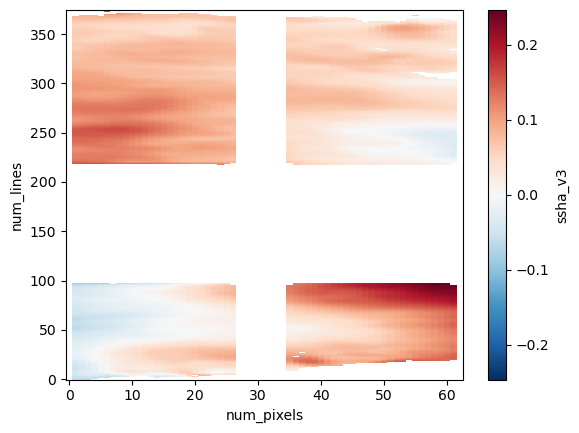

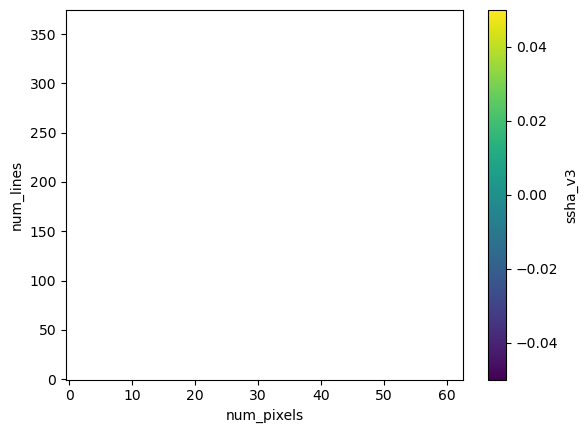

<xarray.DataArray 'ssha_v3' (cycle_num: 96, num_lines: 375, num_pixels: 63)> Size: 18MB
dask.array<concatenate, shape=(96, 375, 63), dtype=float64, chunksize=(1, 116, 32), chunktype=numpy.ndarray>
Coordinates:
  * cycle_num  (cycle_num) int64 768B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
    latitude   (num_lines, num_pixels) float64 189kB dask.array<chunksize=(375, 63), meta=np.ndarray>
    longitude  (num_lines, num_pixels) float64 189kB dask.array<chunksize=(375, 63), meta=np.ndarray>
    time       (cycle_num, num_lines, num_pixels) datetime64[ns] 18MB dask.array<chunksize=(2, 79, 32), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels

In [6]:
ic = 0

ds3 = xr.open_zarr(op.join(sdir,
                     '01-day-repeat/MedSea/Pass%03d.zarr' 
                     % 3)
                  ).isel(num_lines=slice(37,412),
                         num_pixels=slice(3,-3)
                        )

for cc in range(len(ds3.calval)):
    
    ssha = ds3.ssha_v3.isel(calval=cc)
    
    array = ssha.to_masked_array()
    mask = ~array.mask
    ratio = mask.sum() / np.prod(mask.shape)
    if ic == 0:
        R3 = xr.DataArray(np.array([ratio]), 
                         dims='cycle_num', 
                         coords={'cycle_num':np.array([cc,])}
                        )
    else:
        R3 = xr.concat([R3, xr.DataArray(np.array([ratio]), 
                           dims='cycle_num', 
                           coords={'cycle_num':np.array([cc,])}
                                      )
                      ], 'cycle_num')
    if ratio > .7:
        if ic == 0:
            H3 = ssha
        else:
            try:
                H3 = xr.concat([H3, ssha], 'cycle_num')
            except:
                pass
        ic += 1
    else:
        ssha.plot(rasterized=True)
        plt.show()
    del ssha, mask, array

H3.coords["cycle_num"] = R3.where(R3>0.7,drop=True).cycle_num
H3

# Tidying up and filtering data

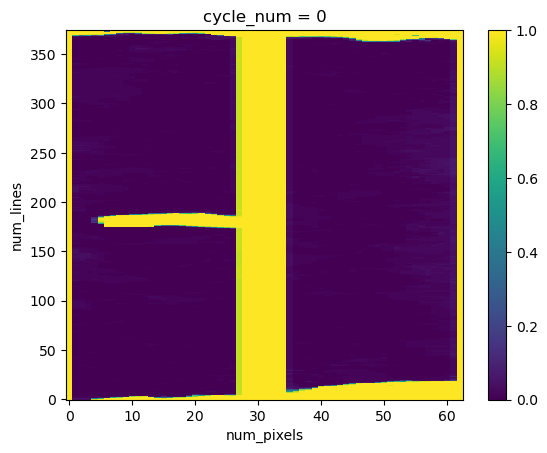

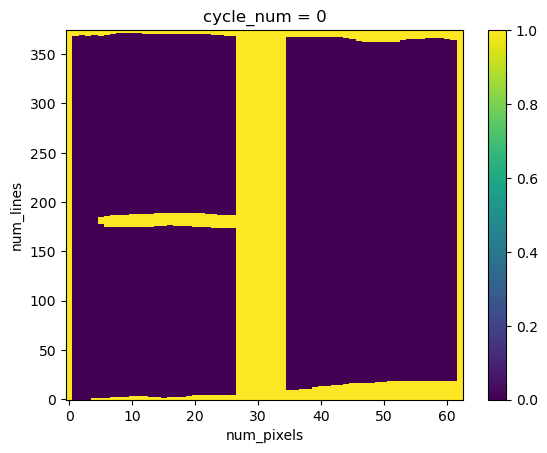

In [7]:
mask3 = xr.DataArray(H3.to_masked_array().mask.mean(axis=0), 
                     dims=H3.isel(cycle_num=0).dims, 
                     coords=H3.isel(cycle_num=0).coords
                    )
mm3 = xr.DataArray(mask3.where(mask3<.35
                              ).to_masked_array().mask,
                   dims=H3.isel(cycle_num=0).dims, 
                   coords=H3.isel(cycle_num=0).coords
                  )
# mm3ns = xr.zeros_like(mm3)
# mm3ns[dict(num_lines=slice(None,30),
#            num_pixels=slice(1,25))] = mm3.isel(num_lines=slice(None,30),
#                                                num_pixels=slice(1,25))
# mm3ns[dict(num_lines=slice(None,30),
#            num_pixels=slice(35,-1))] = mm3.isel(num_lines=slice(None,30),
#                                                num_pixels=slice(35,-1))
# mm3ns[dict(num_lines=slice(-30,None),
#            num_pixels=slice(1,25))] = mm3.isel(num_lines=slice(-30,None),
#                                                num_pixels=slice(1,25))
# mm3ns[dict(num_lines=slice(-30,None),
#            num_pixels=slice(35,-1))] = mm3.isel(num_lines=slice(-30,None),
#                                                num_pixels=slice(35,-1))
# mm3ns[dict(num_pixels=0)] = 1
# mm3ns[dict(num_pixels=-1)] = 1

mask3.plot()
plt.show()
mm3.plot()
plt.show()
# mm3ns.plot()
# plt.show()

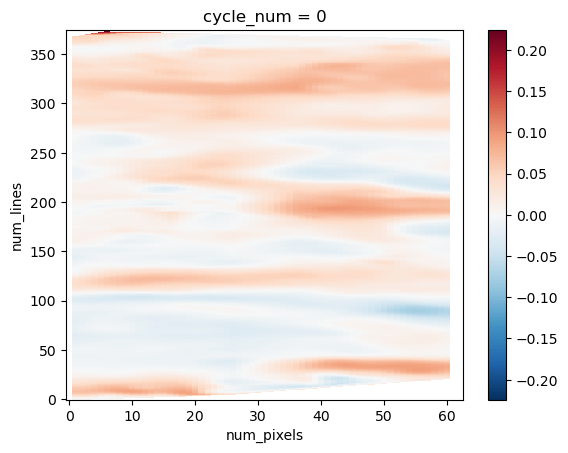

ERROR 1: PROJ: internal_proj_create_from_database: /tank/spectre/tuchida/miniconda3/envs/dmd/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


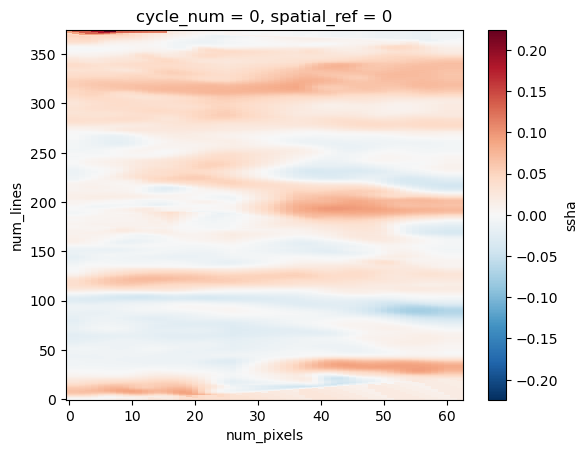

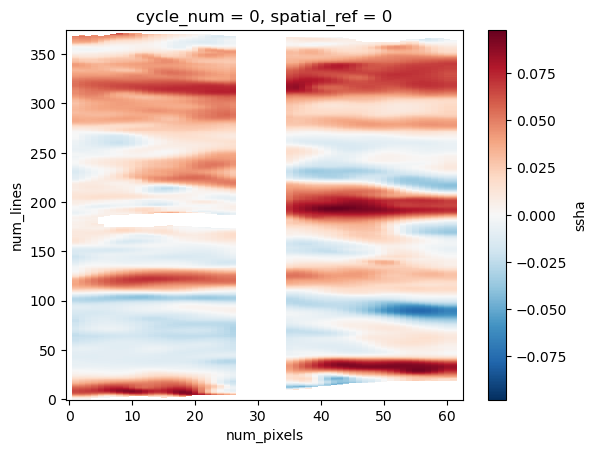

<xarray.DataArray 'ssha' (cycle_num: 96, num_lines: 375, num_pixels: 63)> Size: 18MB
array([[[    nan,  0.0008,  0.0006, ...,     nan,     nan,     nan],
        [    nan,  0.0034,  0.0039, ...,     nan,     nan,     nan],
        [    nan,  0.0114,  0.0119, ...,     nan,     nan,     nan],
        ...,
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]],

       [[    nan, -0.0273, -0.031 , ...,     nan,     nan,     nan],
        [    nan, -0.0317, -0.0345, ...,     nan,     nan,     nan],
        [    nan, -0.0309, -0.0335, ...,     nan,     nan,     nan],
        ...,
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]],

       [[    nan, -0.0272, -0.0275, ...,     nan,     nan,     nan],
        [    nan, -0.0222, -0.0235, ...,     nan,     nan,     nan],
        [    nan, -0.0158, -0.0177, ...,     nan,     nan,     nan],
        ...,
...
        ...,
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]],

       [[    nan,  0.1383,  0.1338, ...,     nan,     nan,     nan],
        [    nan,  0.1395,  0.1349, ...,     nan,     nan,     nan],
        [    nan,  0.1426,  0.1383, ...,     nan,     nan,     nan],
        ...,
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]],

       [[    nan,  0.1138,  0.1093, ...,     nan,     nan,     nan],
        [    nan,  0.1243,  0.1191, ...,     nan,     nan,     nan],
        [    nan,  0.1369,  0.1327, ...,     nan,     nan,     nan],
        ...,
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]]])
Coordinates:
  * cycle_num    (cycle_num) int64 768B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
    y            (num_lines) int64 3kB 0 1 2 3 4 5 6 ... 369 370 371 372 373 374
    x            (num_pixels) int64 504B 0 1 2 3 4 5 6 ... 56 57 58 59 60 61 62
    spatial_ref  int64 8B 0
    latitude     (num_lines, num_pixels) float64 189kB dask.array<chunksize=(375, 63), meta=np.ndarray>
    longitude    (num_lines, num_pixels) float64 189kB dask.array<chunksize=(375, 63), meta=np.ndarray>
    time         (num_lines, num_pixels) datetime64[ns] 189kB dask.array<chunksize=(79, 32), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels
Attributes:
    _FillValue:  nan

In [8]:
# H3_interp = H3.chunk({'num_lines':-1, "num_pixels":-1}
#                   ).interpolate_na(dim='num_pixels', method='linear', 
#                                    fill_value="extrapolate"
#                                   ).interpolate_na(dim='num_lines', method='linear', 
#                                                    fill_value="extrapolate"
#                                                   ).where(mm3!=1)

for cc in H3.cycle_num:
    _ssh = H3.sel(cycle_num=cc)

    x1, y1 = np.meshgrid(np.arange(len(H3.num_pixels)),
                         np.arange(len(H3.num_lines))
                        )
    
    array = np.ma.masked_invalid(_ssh)
    # get only the valid values
    _y1 = y1[~array.mask]
    _x1 = x1[~array.mask]
    newarr = array[~array.mask]
    _ssh = xr.DataArray(griddata((_y1,_x1),
                                 newarr.flatten(), 
                                 (y1,x1), 
                                 method=meth,
                                       # fill_value=0.
                                ), 
                        dims=H3.sel(cycle_num=cc).dims,
                        coords=H3.sel(cycle_num=cc).coords
                       )
    if cc == H3.cycle_num[0]:
        H3_interp = _ssh
        _ssh.plot(rasterized=True)
        plt.show()
    else:
        H3_interp = xr.concat([H3_interp,_ssh], "cycle_num")
    
dsH3 = H3_interp.to_dataset(name="ssha").swap_dims({'num_pixels':'x', 'num_lines':'y'}
                                                  ).reset_coords(drop=True)
dsH3.coords["y"] = ("y",range(len(dsH3.y)))
dsH3.coords["x"] = ("x",range(len(dsH3.x)))
if not dsH3.rio.crs:
    dsH3 = dsH3.rio.write_crs("EPSG:4326")
    # dsH3 = dsH3.rio.write_crs("EPSG:3857")
if dsH3.ssha.rio.nodata is None:
    dsH3["ssha"] = dsH3.ssha.rio.write_nodata(np.nan)
_H3_exterp = dsH3.rio.interpolate_na().swap_dims({'x':'num_pixels', 
                                                 'y':'num_lines'}
                                               ).ssha
_H3_exterp.isel(cycle_num=0).plot(rasterized=True)
plt.show()

H3_exterp = _H3_exterp.where(mm3!=1)
H3_exterp.isel(cycle_num=0).plot(rasterized=True)
plt.show()

# dsH3 = H3.to_dataset(name="ssha").swap_dims({'num_pixels':'x', 'num_lines':'y'}
#                                            ).reset_coords(drop=True)
# dsH3.coords["y"] = ("y",range(len(dsH3.y)))
# dsH3.coords["x"] = ("x",range(len(dsH3.x)))
# dsH3 = dsH3.rio.write_crs("EPSG:3857")
# mask3 = xr.DataArray(dsH3.ssha.to_masked_array().mask,
#                      dims=dsH3.ssha.dims, 
#                      coords=dsH3.ssha.coords
#                     )
# H3_interp = dsH3.rio.interpolate_na().swap_dims({'x':'num_pixels', 
#                                                  'y':'num_lines'}
#                                                ).ssha.reset_coords(drop=True).where(mm3!=1)
# dsH16 = H16.to_dataset(name="ssha").swap_dims({'num_pixels':'x', 'num_lines':'y'}
#                                            ).reset_coords(drop=True)
# dsH16.coords["y"] = ("y",range(len(dsH16.y)))
# dsH16.coords["x"] = ("x",range(len(dsH16.x)))
# dsH16 = dsH16.rio.write_crs("EPSG:3857")
# mask16 = xr.DataArray(dsH16.ssha.to_masked_array().mask,
#                      dims=dsH16.ssha.dims, 
#                      coords=dsH16.ssha.coords
#                      )
# dsH16.rio.interpolate_na()
# H16_interp = dsH16.rio.interpolate_na().swap_dims({'x':'num_pixels', 
#                                                  'y':'num_lines'}
#                                                ).ssha.reset_coords(drop=True).where(mm16!=1)
H3_exterp

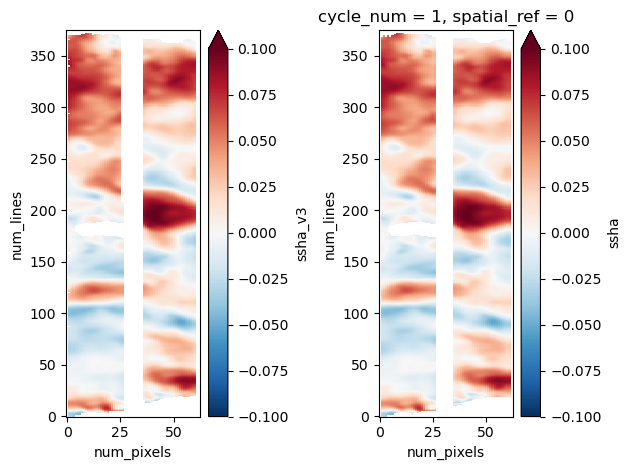

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_tight_layout(True)

ds3.ssha_v3.isel(calval=1).plot(ax=ax1, rasterized=True, vmax=.1)
H3_exterp.isel(cycle_num=1).plot(ax=ax2, rasterized=True, vmax=.1)

In [10]:
iln = 2; ipx = 3
nln = 1; npx = 1

In [12]:
# yy, xx = np.mgrid[ds3.latitude.min(skipna=True).values:ds3.latitude.max(skipna=True).values:np.abs(ds3.latitude.diff('num_lines').min(skipna=True).values),
#                   ds3.longitude.min(skipna=True).values:ds3.longitude.max(skipna=True).values:np.abs(ds3.longitude.diff('num_pixels').min(skipna=True).values)
#                  ]
# lon = griddata((ds3.latitude.values.flatten(),
#                 ds3.longitude.values.flatten()
#                ), 
#                ds3.longitude.values.flatten(), 
#                (yy, xx), method='linear'
#               )
# lat = griddata((ds3.latitude.values.flatten(),
#                 ds3.longitude.values.flatten()
#                ), 
#                ds3.latitude.values.flatten(), 
#                (yy, xx), method='linear'
#               )

# for cc in range(len(H3_exterp.cycle_num)):
#     ssh = griddata((ds3.latitude.values.flatten(),
#                     ds3.longitude.values.flatten()
#                    ), 
#                    H3_exterp.isel(cycle_num=cc).values.flatten(), 
#                    (yy, xx), method=meth
#                   )

#     dss = xr.DataArray(ssh, dims=['YC','XC'], 
#                        coords={'YC':np.mean(yy, axis=1),
#                                'XC':np.mean(xx, axis=0)}
#                       ).to_dataset(name='ssh')
#     if cc % 20 == 0:
#         dss.ssh.plot(rasterized=True)
#         plt.show()

#     dx = gsw.distance(lon, lat, p=0, axis=-1)
#     dy = gsw.distance(lon, lat, p=0, axis=0)
#     dss.coords['dxC'] = xr.DataArray(dx, dims=['YC','XF'],
#                               coords={'YC':np.mean(yy, axis=1),
#                                       'XF':np.mean(.5*(xx[:,1:] + xx[:,:-1]), 
#                                                    axis=0)}
#                      )
#     dss.coords['dyC'] = xr.DataArray(dy, dims=['YF','XC'],
#                               coords={'YF':np.mean(.5*(yy[1:] + yy[:-1]), 
#                                                    axis=1),
#                                       'XC':np.mean(xx, axis=0)}
#                      )


#     coords={
#             'X':{'center':'XC', 'inner':'XF'}, 
#             'Y':{'center':'YC', 'inner':'YF'},
#            }
#     grid = Grid(dss, periodic=[], coords=coords)

#     dxG = grid.interp(grid.interp(dss.dxC,'X',boundary='extend'),
#                       'Y',boundary='extend',to='inner')
#     dyG = grid.interp(grid.interp(dss.dyC,'X',boundary='extend',to='inner'),
#                       'Y',boundary='extend')
#     dxF = grid.interp(dss.dxC,'X',boundary='extend')
#     dyF = grid.interp(dss.dyC,'Y',boundary='extend')

#     mask = ~dss.ssh.to_masked_array().mask
#     # mask = mm3.where(mm3==0).to_masked_array().mask

#     wet_mask = xr.DataArray(np.zeros((len(dss.YC),len(dss.XC))),
#                             dims=['YC','XC'],
#                             coords={'YC':dss.YC,'XC':dss.XC}
#                    )
#     wet_mask[1:-1,1:-1] = mask[1:-1,1:-1].astype(np.float64)
#     # if cc == H_interp.cycle_num[0]:
#     #     wet_mask.plot(rasterized=True)
#     #     plt.show()

#     area = (dxF * dyF)

#     dxw = xr.DataArray(np.pad(dss.dxC.data, ((0,0),(0,1)), 'edge'),
#                        dims=area.dims, coords=area.coords
#                       ) # x-spacing centered at western cell edge
        
#     dyw = xr.DataArray(np.pad(dyG.data, ((0,0),(0,1)), 'edge'),
#                        dims=area.dims, coords=area.coords
#                       ) # y-spacing centered at western cell edge
        
#     dxs = xr.DataArray(np.pad(dxG.data, ((0,1),(0,0)), 'edge'),
#                        dims=area.dims, coords=area.coords
#                       ) # x-spacing centered at southern cell edge
        
#     dys = xr.DataArray(np.pad(dss.dyC.data, ((0,1),(0,0)), 'edge'),
#                        dims=area.dims, coords=area.coords
#                       ) # y-spacing centered at southern cell edge
        
#     dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min())
#     dx_min = dx_min.values
        
#     kappa_w = xr.ones_like(wet_mask)
#     kappa_s = xr.ones_like(wet_mask)

#     filter_scale = 8_000
#     filt_mask = wet_mask.chunk({'YC':-1,'XC':-1}).reset_coords(drop=True)
        
#     filter = gcm_filters.Filter(
#                 filter_scale=filter_scale,
#                 dx_min=dx_min,
#             #     n_steps=36,
#                 filter_shape=gcm_filters.FilterShape.GAUSSIAN,
#                 grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
#                 grid_vars={
#                     'wet_mask': filt_mask, 
#                     'dxw': dxw.chunk({'YC':-1,'XC':-1}), 
#                     'dyw': dyw.chunk({'YC':-1,'XC':-1}), 
#                     'dxs': dxs.chunk({'YC':-1,'XC':-1}), 
#                     'dys': dys.chunk({'YC':-1,'XC':-1}), 
#                     'area': area.chunk({'YC':-1,'XC':-1}), 
#                     'kappa_w': kappa_w.chunk({'YC':-1,'XC':-1}), 
#                     'kappa_s': kappa_s.chunk({'YC':-1,'XC':-1})
#                 }
#             )
    
#     _sshm = filter.apply(dss.ssh.chunk({'YC':-1,'XC':-1}), 
#                          dims=['YC','XC']
#                         ).reset_coords(drop=True)

#     _sshm = griddata((yy.flatten(), xx.flatten()), 
#                      _sshm.values.flatten(), 
#                      (H3_interp.latitude.values,
#                       H3_interp.longitude.values), 
#                      method=meth
#                     )
#     array = np.ma.masked_invalid(_sshm)
#     # get only the valid values
#     y1 = ds3.latitude.values[~array.mask]
#     x1 = ds3.longitude.values[~array.mask]
#     newarr = array[~array.mask]
#     _sshm = xr.DataArray(griddata((y1,x1),
#                                  newarr.flatten(), 
#                                  (ds3.latitude.values,
#                                   ds3.longitude.values), 
#                                  method=meth,
#                                        # fill_value=0.
#                                 ), 
#                         dims=H3_interp.isel(cycle_num=cc).dims,
#                         coords=H3_interp.isel(cycle_num=cc).coords
#                        )
#     sshm = _sshm.where(mm3!=1).isel(num_lines=slice(iln,-iln),
#                                     num_pixels=slice(ipx,-ipx)
#                                    )
 
#     if cc == 0:
#         # dsave = dss
#         ssha = sshm.reset_coords(drop=True)
#         ssha.plot(rasterized=True)
#         plt.show()
#     else:
#         # dsave = xr.concat([dsave, dss
#         #                   ], 'cycle_num')
#         ssha = xr.concat([ssha, sshm.reset_coords(drop=True)
#                          ], 'cycle_num')
#         if cc % 20 == 0:
#             ssha.isel(cycle_num=cc).plot(rasterized=True)
#             plt.show()
#     del _sshm, sshm
#     dss.close()

# # dsave.to_zarr(op.join(sdir,
# #                       '01-day-repeat/MedSea/Pass003/raw-gridded_'+meth+'.zarr' 
# #                       ), mode='w'
# #              )
# # dsave.close()

# ssha.coords['cycle_num'] = H3_exterp.cycle_num
# dsave = ssha.to_dataset(name='ssha')
# print(dsave)
# dsave.to_zarr(op.join(sdir,
#                       '01-day-repeat/MedSea/Pass003/ssha_'+meth+'_%02dkm.zarr' 
#                       % (filter_scale*1e-3)), mode='w'
#              )
# dsave.close()

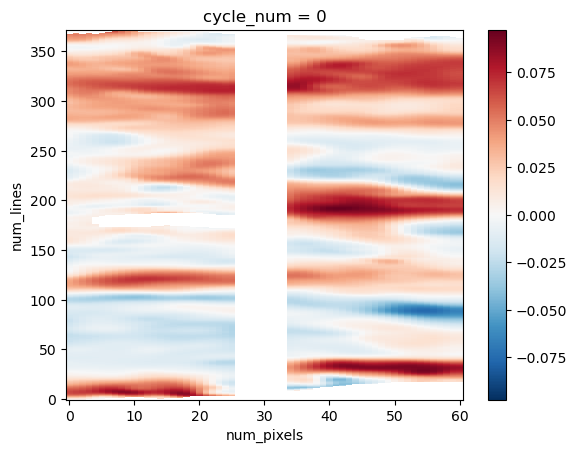

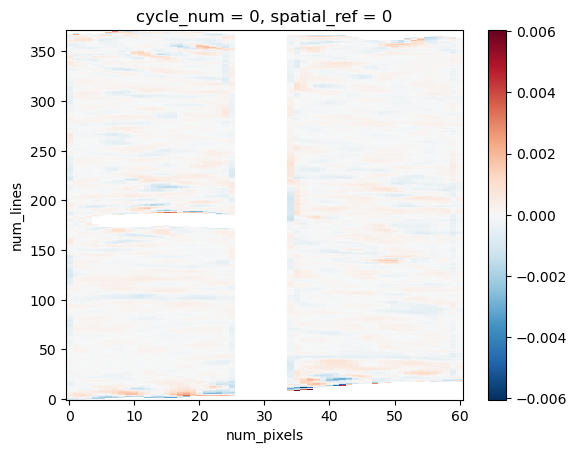

In [11]:
# wet_mask = xr.ones_like(_H3_exterp.isel(cycle_num=0)).reset_coords(drop=True)
# wet_mask[0] = 0
# wet_mask[-1] = 0
# wet_mask[:,0] = 0
# wet_mask[:,-1] = 0
wet_mask = xr.DataArray(mm3.where(mm3==1).to_masked_array().mask.astype(np.float64),
                        dims=mm3.dims, coords=mm3.coords
                       ).reset_coords(drop=True)
regular_filter = gcm_filters.Filter(
    filter_scale=np.ceil(8/np.sqrt(12)/2),
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask,
    }
)

_sshm = regular_filter.apply(_H3_exterp.chunk({'num_lines':-1,'num_pixels':-1}), 
                         dims=['num_lines','num_pixels']
                        ).reset_coords(drop=True).where(mm3!=1).chunk({"cycle_num":1,
                                                         "num_lines":-1,"num_pixels":-1}
                                                       ).isel(num_pixels=slice(npx,-npx),
                                                              num_lines=slice(nln,-nln-1)
                                                             )
_sshm.isel(cycle_num=0).plot()
plt.show()
(_H3_exterp.isel(num_pixels=slice(1,-1),num_lines=slice(1,-2)) 
 - _sshm).isel(cycle_num=0).plot()
plt.show()
dsave = _sshm.to_dataset(name="ssha"
                        ).to_zarr(op.join(sdir,
                      '01-day-repeat/MedSea/Pass003/ssha_rawgrid_%02dpoints.zarr' 
                      % int(np.ceil(8/np.sqrt(12)/2))), mode='w'
             )

# Start applying DMD

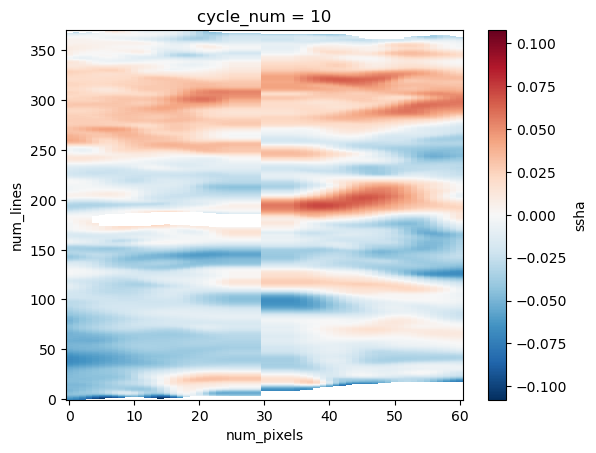

(<xarray.DataArray 'ssha' (cycle_num: 98, num_lines: 372, num_pixels: 61)> Size: 18MB
 dask.array<transpose, shape=(98, 372, 61), dtype=float64, chunksize=(98, 372, 61), chunktype=numpy.ndarray>
 Coordinates:
   * cycle_num   (cycle_num) int64 784B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
   * num_lines   (num_lines) int64 3kB 0 1 2 3 4 5 6 ... 366 367 368 369 370 371
   * num_pixels  (num_pixels) int64 488B 0 1 2 3 4 5 6 7 ... 54 55 56 57 58 59 60
     latitude    (num_lines, num_pixels) float64 182kB dask.array<chunksize=(372, 61), meta=np.ndarray>
     longitude   (num_lines, num_pixels) float64 182kB dask.array<chunksize=(372, 61), meta=np.ndarray>
     time        (num_lines, num_pixels) datetime64[ns] 182kB dask.array<chunksize=(372, 61), meta=np.ndarray>,
 <xarray.DataArray 'ssha' (cycle_num: 98, num_lines: 371, num_pixels: 53)> Size: 15MB
 dask.array<where, shape=(98, 371, 53), dtype=float64, chunksize=(98, 371, 53), chunktype=numpy.ndarray>
 Coordinates:
   * cycle_num   (cycl

In [12]:
fscale = 2
# h_interp = xr.open_zarr(op.join(sdir,
#                         '01-day-repeat/MedSea/Pass003/ssha_linear_%02dkm.zarr' 
#                         % (fscale))
#                        ).ssha.isel(num_lines=slice(1,-1)
#                                   ).chunk({'num_pixels':-1,
#                                            'num_lines':-1}
#                       ).interpolate_na(dim='num_pixels', method='slinear', 
#                                        fill_value="extrapolate"
#                                       ).interpolate_na(dim='num_lines', 
#                                                        method='slinear', 
#                                                        fill_value="extrapolate"
#                                     ).interp(cycle_num=np.arange(len(ds3.calval)))
h_interp = xr.open_zarr(op.join(sdir,
                        '01-day-repeat/MedSea/Pass003/ssha_rawgrid_%02dpoints.zarr' 
                        % (fscale))
                       ).ssha.interp(cycle_num=np.arange(len(ds3.calval))
                                    )
h_interp.coords["num_pixels"] = ("num_pixels", range(len(h_interp.num_pixels)))
h_interp.coords["num_lines"] = ("num_lines", range(len(h_interp.num_lines)))
maskh = xr.DataArray(h_interp.to_masked_array().mask,
                     dims=h_interp.dims, coords=h_interp.coords
                    )
h_dropped = h_interp.where(~maskh, drop=True)

h_dropped.isel(cycle_num=10).plot(rasterized=True)
plt.show()
h_interp, h_dropped

In [13]:
print(h_interp.num_pixels, h_dropped.num_pixels)
print(h_interp.num_lines, h_dropped.num_lines)

<xarray.DataArray 'num_pixels' (num_pixels: 61)> Size: 488B
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60])
Coordinates:
  * num_pixels  (num_pixels) int64 488B 0 1 2 3 4 5 6 7 ... 54 55 56 57 58 59 60 <xarray.DataArray 'num_pixels' (num_pixels: 53)> Size: 424B
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])
Coordinates:
  * num_pixels  (num_pixels) int64 424B 0 1 2 3 4 5 6 7 ... 54 55 56 57 58 59 60
<xarray.DataArray 'num_lines' (num_lines: 372)> Size: 3kB
array([  0,   1,   2, ..., 369, 370, 371])
Coordinates:
  * num_lines  (num_lines) int64 3kB 0 1 2 3 4 5 6 ... 366 367 368 369 

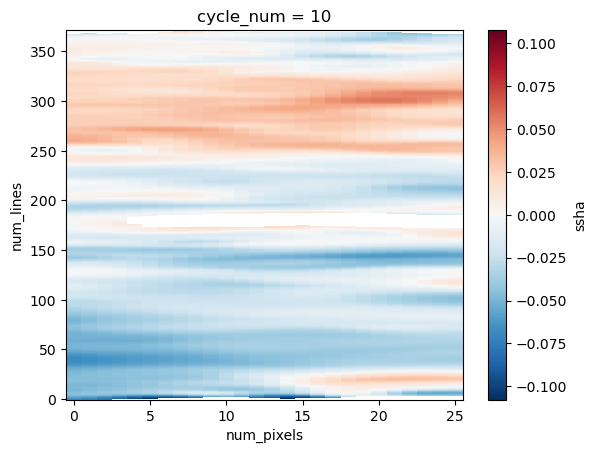

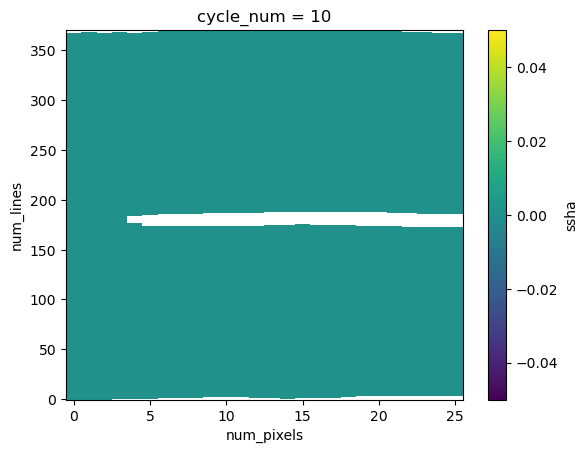

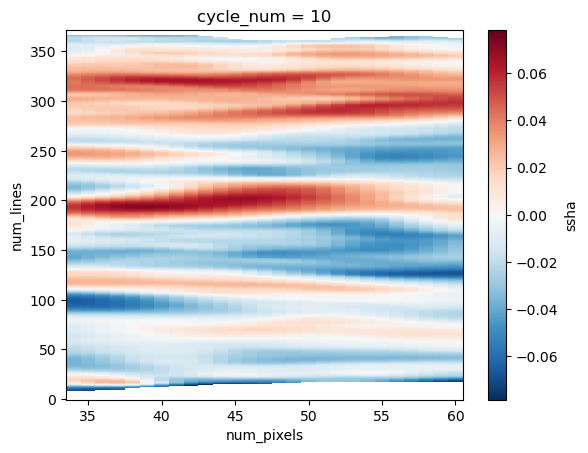

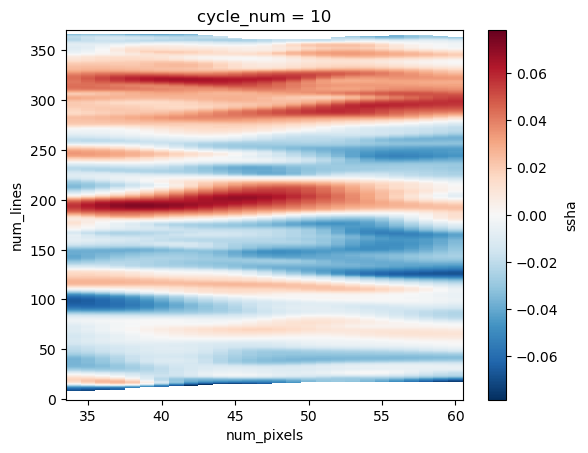

In [14]:
# h_interp.isel(cycle_num=10,num_pixels=slice(None,25),num_lines=slice(None,-2)).plot(rasterized=True)
# plt.show()
# (h_interp.isel(cycle_num=10,num_pixels=slice(None,24),num_lines=slice(None,-2))
#  - h_dropped.isel(cycle_num=10,num_pixels=slice(None,24))
# ).plot(rasterized=True)
# plt.show()
# h_interp.isel(cycle_num=10,num_pixels=slice(31,None),num_lines=slice(None,-2)).plot(rasterized=True)
# plt.show()
h_interp.isel(cycle_num=10,num_pixels=slice(None,26),num_lines=slice(None,None)).plot(rasterized=True)
plt.show()
(h_interp.isel(cycle_num=10,num_pixels=slice(None,26),num_lines=slice(None,None))
 - h_dropped.isel(cycle_num=10,num_pixels=slice(None,26))
).plot(rasterized=True)
plt.show()
h_interp.isel(cycle_num=10,num_pixels=slice(-27,None),num_lines=slice(None,None)).plot(rasterized=True)
plt.show()
h_dropped.isel(cycle_num=10,num_pixels=slice(-27,None),num_lines=slice(None,None)).plot(rasterized=True)
plt.show()

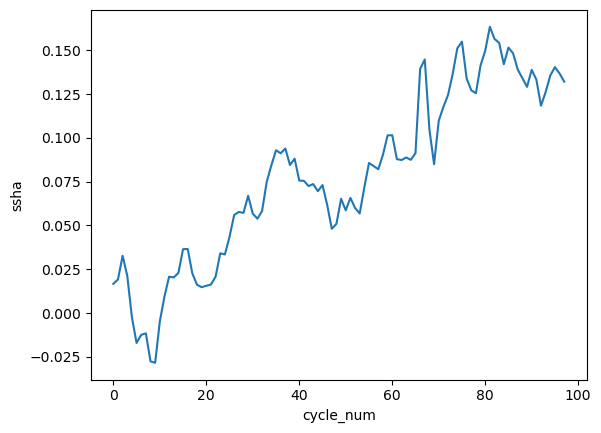

In [15]:
h_dropped.mean(['num_lines','num_pixels'],skipna=True).plot()

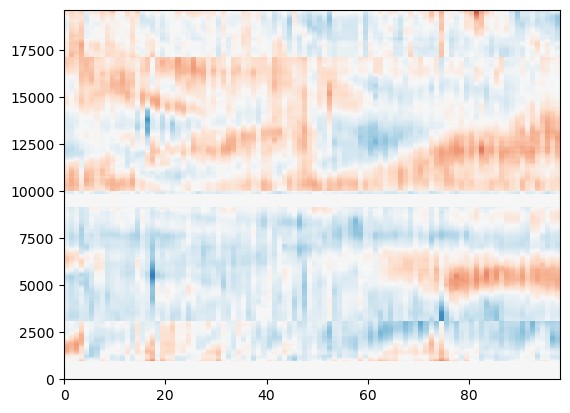

<xarray.DataArray 'ssha' (z: 19663, cycle_num: 98)> Size: 15MB
dask.array<transpose, shape=(19663, 98), dtype=float64, chunksize=(1750, 98), chunktype=numpy.ndarray>
Coordinates:
  * z           (z) object 157kB MultiIndex
  * cycle_num   (cycle_num) int64 784B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
    latitude    (z) float64 157kB dask.array<chunksize=(1750,), meta=np.ndarray>
    longitude   (z) float64 157kB dask.array<chunksize=(1750,), meta=np.ndarray>
    time        (z) datetime64[ns] 157kB dask.array<chunksize=(1750,), meta=np.ndarray>
  * num_lines   (z) int64 157kB 0 0 0 0 0 0 0 0 ... 370 370 370 370 370 370 370
  * num_pixels  (z) int64 157kB 0 1 2 3 4 5 6 7 8 ... 52 53 54 55 56 57 58 59 60

In [16]:
zchunk = 1750
h_stacked = (h_dropped 
             - h_dropped.mean(['num_lines','num_pixels'],skipna=True)
            ).stack(z=('num_lines','num_pixels')
                          ).chunk({'z':zchunk}).fillna(0.)
# h_stacked = h_interp.stack(z=("YC", "XC")
#                           ).chunk({'z':zchunk}).fillna(0.)

fig, ax = plt.subplots()
ax.pcolormesh(h_stacked.T.values, 
              rasterized=True,  
              vmax=.2, vmin=-.2, cmap='RdBu_r')
plt.show()
h_stacked.T

In [17]:
nh3 = ds3.time.astype('datetime64[s]').mean(["num_lines","num_pixels"]
                  ).diff("calval").mean().astype(np.float64).values
window_lengths = np.ceil( np.array([8, 9, 10, 30, 60])
                         * 86400/nh3 ).astype(int) # 24 hourly
step_sizes = np.array([1, 1, 1, 1, 1])
print(window_lengths, "[days]")
nh3 / 86400.

[ 8  9 10 29 57] [days]


1.0651967592592593

In [18]:
fit = False

In [16]:
# sr = 4
# svd_ranks = [sr] * len(window_lengths)
svd_ranks = [4, 4, 4, 10, 12]
if len(svd_ranks) != len(window_lengths):
    print("######### WRONG LENGTHS #########")
suppress_growth = True
transform_method = "absolute"
# n_components_array = [2] * len(window_lengths)
global_svd_array = [False] * len(window_lengths)
# kern_method = "flat"
# real_eig_limit = 0.5
# pydmd_kwargs = {
#     "eig_constraints": {"conjugate_pairs", "limited"},
#     "real_eig_limit": real_eig_limit,
# }

dmd = mrCOSTS(
    svd_rank_array=svd_ranks,
    window_length_array=window_lengths,
    step_size_array=step_sizes,
    global_svd_array=global_svd_array,
    cluster_sweep=True,
    transform_method=transform_method,
    # kern_method=kern_method,
    # relative_filter_length=relative_filter_length,
    # pydmd_kwargs=pydmd_kwargs,
)

if fit:
    dmd.fit(h_stacked.values.T, 
            np.atleast_2d(np.arange(len(h_stacked.cycle_num)
                                   ) * nh3)
           )

_________________________________________________
Fitting window length = 8
0 of 91
50 of 91
Error in Global Reconstruction = 0.21
_________________________________________________
Fitting window length = 9
0 of 90
50 of 90
Error in Global Reconstruction = 0.081
_________________________________________________
Fitting window length = 10
0 of 89
50 of 89
Error in Global Reconstruction = 0.062
_________________________________________________
Fitting window length = 29
0 of 70
50 of 70
Error in Global Reconstruction = 0.12
_________________________________________________
Fitting window length = 57
0 of 42
Error in Global Reconstruction = 0.13


In [19]:
if fit:
    # dmd.to_netcdf(op.join(ddir, 
    #                       "SWOT/CalVal/mrCOSTS_h/%02dhourly/%02d_fit"
    #                       % (nh,len(window_lengths))
    #                      )
    #              )
    dmd.to_netcdf(op.join(ddir, 
                  "SWOT/CalVal/mrCOSTS_h/MedSea/Pass%03d_%02d_raw_%02dpoints"
                  % (3,len(window_lengths),2)
                         )
                 )
else:
    mrc = glob.glob(op.join(ddir, 
                "SWOT/CalVal/mrCOSTS_h/MedSea/Pass%03d_05_raw_*.nc"
                % (3)
                           )
                   )
    print(mrc)
    dmd = mrCOSTS()
    dmd.from_netcdf(mrc)

['/tank/spectre/tuchida/DMD/SWOT/CalVal/mrCOSTS_h/MedSea/Pass003_05_raw_02points.window=57.nc', '/tank/spectre/tuchida/DMD/SWOT/CalVal/mrCOSTS_h/MedSea/Pass003_05_raw_02points.window=9.nc', '/tank/spectre/tuchida/DMD/SWOT/CalVal/mrCOSTS_h/MedSea/Pass003_05_raw_02points.window=8.nc', '/tank/spectre/tuchida/DMD/SWOT/CalVal/mrCOSTS_h/MedSea/Pass003_05_raw_02points.window=29.nc', '/tank/spectre/tuchida/DMD/SWOT/CalVal/mrCOSTS_h/MedSea/Pass003_05_raw_02points.window=10.nc']


# DMD outputs

In [20]:
dmd.multi_res_interp()
dmd._da_omega

<xarray.DataArray 'omega' (window_length: 5, window_time_means: 91, svd_rank: 12)> Size: 87kB
array([[[-5.35245139e-08+2.04082068e-05j,
         -5.35245139e-08-2.04082068e-05j,
                     nan           +nanj, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        [-5.16871078e-06+2.46251588e-05j,
         -5.16871078e-06-2.46251588e-05j,
                     nan           +nanj, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        [            nan           +nanj,
                     nan           +nanj,
         -6.40412220e-06+2.12416271e-05j, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        ...,
        [            nan           +nanj,
...
                     nan           +nanj],
        ...,
        [            nan           +nanj,
                     nan           +nanj,
                     nan           +nanj, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        [            nan           +nanj,
                     nan           +nanj,
                     nan           +nanj, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        [            nan           +nanj,
                     nan           +nanj,
                     nan           +nanj, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj]]])
Coordinates:
  * window_length        (window_length) int64 40B 8 9 10 29 57
  * window_time_means    (window_time_means) float64 728B 3.221e+05 ... 8.605...
  * svd_rank             (svd_rank) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
    slide                (window_length, window_time_means) float64 4kB 0.0 ....
    decomposition_level  (window_length) int64 40B 0 1 2 3 4

fitting n_components = 4
fitting n_components = 5
fitting n_components = 6
fitting n_components = 7
fitting n_components = 8
fitting n_components = 9
fitting n_components = 10
fitting n_components = 11
fitting n_components = 12
fitting n_components = 13
fitting n_components = 14
fitting n_components = 15
fitting n_components = 16
fitting n_components = 17
fitting n_components = 18
fitting n_components = 19
fitting n_components = 20
fitting n_components = 21
fitting n_components = 22
fitting n_components = 23
fitting n_components = 24
fitting n_components = 25
fitting n_components = 26
fitting n_components = 27
fitting n_components = 28
fitting n_components = 29
Optimal silhouette score is = 11


Text(0, 0.5, 'Silhouette score (-), (1 is best, -1 is worst)')

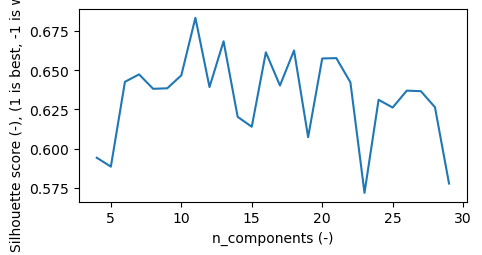

In [21]:
n_components_range = np.arange(4, 30)
scores, n3_optimal = dmd.global_cluster_hyperparameter_sweep(
    n_components_range,
    transform_method="log10",
)

print("Optimal silhouette score is = {}".format(n3_optimal))
plt.figure(figsize=(5, 2.5))
plt.plot(n_components_range, scores)
plt.gca().set_xlabel("n_components (-)")
plt.gca().set_ylabel("Silhouette score (-), (1 is best, -1 is worst)")

In [22]:
# n_ops = 10
cluster_centroids3, omega_classes, omega_array = dmd.global_cluster_omega(
    n3_optimal,
    # n_ops,
    transform_method="log10"
)
cluster_centers_periods3 = 1 / (10 ** (cluster_centroids3) / (2 * np.pi))

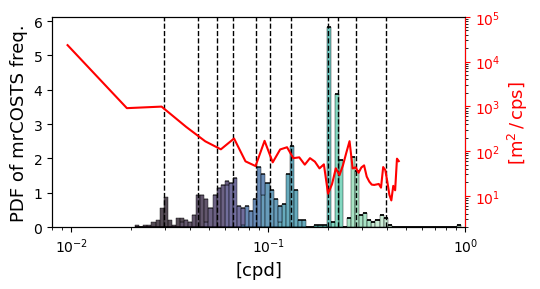

In [23]:
x_trans = (2 * np.pi / 10**omega_array / 86400.)**-1
# unique_labels, label_counts = np.unique(omega_classes, return_counts=True)
# weights = label_counts.max() / label_counts
# x_trans_labels = [x_trans[omega_classes == label] for label in unique_labels]

# weights_labels = []
# unique_labels = unique_labels.astype(int)
# for label in unique_labels:
#     ind_array = np.flatnonzero(unique_labels == label)
#     ind_list = int(ind_array)
#     w = weights[ind_array]
#     x_w = x_trans_labels[ind_list]
#     w_broadcast = np.broadcast_to(w, (x_w.shape))
#     weights_labels.append(w_broadcast)
hue_order = np.arange(len(np.unique(omega_classes))).astype(str)
cluster_centers3 = 1 / ((10 ** cluster_centroids3) / (2 * np.pi) / 86400.)

# Make a continuous color palette with the brightest and darkest excluded
palette = sns.color_palette("mako", len(cluster_centers3) + 2)
# palette = palette[1:-1]


Fh = xrft.power_spectrum(h_dropped[...,::150,10::40
                         ].chunk({'cycle_num':-1}
                                ).assign_coords({'cycle_num':
                                                 np.arange(len(h_interp.cycle_num)) 
                                                 * nh3}
                                               ), 
                         dim='cycle_num', window='hann', window_correction=True
                        ).astype(np.single)

from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(5.5, 3))
ax2 = ax.twinx()
fig.set_tight_layout(True)

ax2.plot(Fh.freq_cycle_num.isel(freq_cycle_num=slice(len(Fh.freq_cycle_num)//2+1,None)
                               )*86400, 
         Fh.isel(freq_cycle_num=slice(len(Fh.freq_cycle_num)//2+1,None)
                ).mean(['num_pixels','num_lines'],skipna=True)*2,
         c='r', label=r"Fourier")

# ax = plt.gca()
ax.set_xscale("log")
# ax2.set_xscale("log")
ax2.set_yscale("log")
# ax.set_title(
#     "Global histogram of frequencies; Interpolated decomposition levels"
# )
# ax.set_xlabel(r"Period; $(2 \pi) / Im(|\omega|)$ [day]")

# ax.hist(
#     x=x_trans_labels,
#     bins=np.logspace(stop=np.log10((1.9e4/86400)**-1), 
#                      start=np.log10((1.5e6/86400)**-1), 
#                      num=200),
#     histtype="barstacked",
#     weights=weights_labels,
#     # alpha=.8,
# )
sns.histplot(
    # x=((10**omega_array) / (2 * np.pi) / 86400.),
    x=x_trans,
    hue=omega_classes,
    hue_order=hue_order,
    common_bins=True,
    common_norm=True,
    stat="density",
    multiple="stack",
    bins=80,
    palette=ListedColormap(palette),
    legend=False,
    ax=ax
)

ax.set_xlabel(r"[cpd]", fontsize=13)
ax.set_ylabel("PDF of mrCOSTS freq.", fontsize=13)
ax2.set_ylabel("[m$^2\,/\,$cps]", fontsize=13, c='r')

ax.set_xlim([8e-3,1e0])
# ax2.set_xlim([8e-3,1.5e1])
ax2.set_ylim([2e0,1e5])

# ax2.fill_between(np.array([1/(24.*2*3600.)*86400, 1/(24.*3600.)*86400]), 
#                  2e1, 1e5, 
#                  color='r', alpha=.15)
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')

[
    ax.axvline((2 * np.pi / (10**c) / 86400)**-1, color="k", ls="--", lw=1)
    for nc, c in enumerate(cluster_centroids3)
];
# ylim_bottom, ylim_top = ax.get_ylim()
# [
#     ax.text(
#         2 * np.pi / (10**c),
#         ylim_top - ylim_top * 0.1,
#         "{:4.0f}d".format(1 / (10 ** (c) / (2 * np.pi))),
#         rotation="vertical",
#         va="top",
#         ha="right",
#     )
#     for c in cluster_centroids
# ];

# y_lim_bottom, y_lim_top = ax.get_ylim()
# [
#     ax.text(
#         c,
#         y_lim_top - y_lim_top * 0.2,
#         # "{:0.2f} Hz".format(c),
#         rotation="vertical",
#         va="top",
#         ha="right",
#     )
#     for c in cluster_centers
# ];
plt.savefig(op.join(sdir,'Figs/SWOT-MedSea_Pass003-raw_mrCOSTS_hist-%02d_%02dpoints.pdf' 
                    % (len(window_lengths),fscale))
           )

In [24]:
np.where((2 * np.pi / (10**cluster_centroids3) 
          / 86400)**-1 < 1e-1)

(array([0, 1, 2, 3, 4]),)

In [25]:
omega_classes_list = dmd.multi_res_deterp()

(19663, 98) <xarray.DataArray 'ssha' (cycle_num: 98, z: 19663)> Size: 15MB
dask.array<where, shape=(98, 19663), dtype=float64, chunksize=(98, 1750), chunktype=numpy.ndarray>
Coordinates:
  * cycle_num   (cycle_num) int64 784B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
  * z           (z) object 157kB MultiIndex
    latitude    (z) float64 157kB dask.array<chunksize=(1750,), meta=np.ndarray>
    longitude   (z) float64 157kB dask.array<chunksize=(1750,), meta=np.ndarray>
    time        (z) datetime64[ns] 157kB dask.array<chunksize=(1750,), meta=np.ndarray>
  * num_lines   (z) int64 157kB 0 0 0 0 0 0 0 0 ... 370 370 370 370 370 370 370
  * num_pixels  (z) int64 157kB 0 1 2 3 4 5 6 7 8 ... 52 53 54 55 56 57 58 59 60


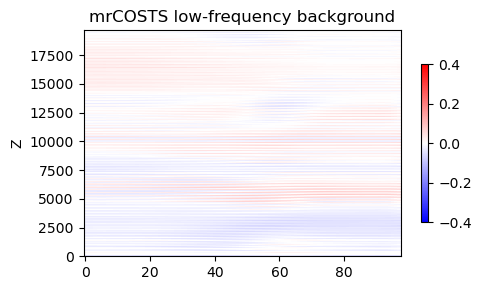

In [46]:
xr_background = dmd.get_background()
print(xr_background.shape, h_stacked)

bg_unstacked = xr.DataArray(xr_background, dims=h_stacked.T.dims,
                            coords=h_stacked.T.coords
                           ).unstack().chunk({'cycle_num':1})
ds_global_background = h_interp.copy()
# ds_global_background.loc[dict(num_lines=background_unstacked.num_lines, 
#                               num_pixels=background_unstacked.num_pixels)
# ] = background_unstacked
ds_global_background[dict(num_pixels=slice(None,26),
                          num_lines=slice(None,-1))
] = bg_unstacked[dict(num_pixels=slice(None,26))]
ds_global_background[dict(num_pixels=slice(-27,None),
                          num_lines=slice(None,-1))
] = bg_unstacked[dict(num_pixels=slice(-27,None))]
ds_global_background.where(mm3.isel(num_pixels=slice(npx,-npx),
                                    num_lines=slice(nln,-nln-1)
                                   )!=1).chunk(
        {'num_pixels':-1, 'num_lines':-1}
).to_dataset(name='background'
            ).to_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/MedSea/Pass%03d/background-raw_%02dpoints.zarr' 
                              % (3, fscale)),
                              mode='w')

fig, ax = plt.subplots(figsize=(5, 3))
fig.set_tight_layout(True)
im = ax.pcolormesh(
    h_stacked.cycle_num,
    np.arange(len(h_stacked.z)), 
    xr_background, 
    vmin=-.4, vmax=.4, cmap="bwr",
    rasterized=True
)
ax.set_title("mrCOSTS low-frequency background")
ax.set_ylabel("Z")
# fig.autofmt_xdate()
fig.colorbar(im, shrink=.7)

In [42]:
xr_sep = dmd.global_scale_reconstruction()

In [43]:
(dmd.n_decompositions, 
 (dmd.ragged_omega_classes[0]>-1).shape, 
 dmd.ragged_amplitudes_array[0].shape)

(5, (91, 12), (91, 4))

In [47]:
for ncl_center, cl_center in enumerate(cluster_centers_periods3):
    
    ds_xr_sep = xr.DataArray(
        xr_sep.real[:, ncl_center],
        dims=["decomp_level", "z", "cycle_num"],
        coords=[
            np.arange(len(dmd.costs_array)),
            # np.arange(n_optimal),
            h_stacked.z,
            h_stacked.cycle_num,
        ],
    )
    
    for dd in ds_xr_sep.decomp_level:
        if dd == 0:
            ds_global_separation = h_interp.copy()
            sep_unstacked = ds_xr_sep.sel(decomp_level=dd
                                 ).unstack().chunk({'cycle_num':1})
            ds_global_separation[dict(num_pixels=slice(None,26),
                                      num_lines=slice(None,-1))
            ] = sep_unstacked[dict(num_pixels=slice(None,26))]
            ds_global_separation[dict(num_pixels=slice(-27,None),
                                      num_lines=slice(None,-1))
            ] = sep_unstacked[dict(num_pixels=slice(-27,None))]
        else:
            tmp = h_interp.copy()
            sep_unstacked = ds_xr_sep.sel(decomp_level=dd
                                 ).unstack().chunk({'cycle_num':1})
            tmp[dict(num_pixels=slice(None,26),
                                      num_lines=slice(None,-1))
            ] = sep_unstacked[dict(num_pixels=slice(None,26))]
            tmp[dict(num_pixels=slice(-27,None),
                                      num_lines=slice(None,-1))
            ] = sep_unstacked[dict(num_pixels=slice(-27,None))]
            ds_global_separation = xr.concat([ds_global_separation,
                                              tmp
                                             ], 'decomp_level'
                                            )
            del tmp

    ds_global_separation = ds_global_separation.where(mm3.isel(num_pixels=slice(npx,-npx),
                                                               num_lines=slice(nln,-nln-1)
                                                              )!=1).chunk({'cycle_num':1})
    # ds_xr_sep.isel(decomp_level=0).sum("cluster").plot(rasterized=True)
    ds_cluster_centers = xr.DataArray(
        np.array([1 / (10 ** (cluster_centroids3[ncl_center]) / (2 * np.pi)),]),
        dims=["cluster"],
        # coords=[np.arange(n_optimal)],
        coords=[np.array([ncl_center,])],
    )
    ds_cluster_centers.attrs["units"] = "s"
    ds_cluster_centers.attrs["long_name"] = "Central period of each period band"
    
    ds_global_separation = ds_global_separation.to_dataset(name="frequency_bands")
    ds_global_separation["frequency_bands"].attrs["units"] = "m"
    ds_global_separation["frequency_bands"].attrs["long_name"] = "mrCOSTS"
    
    ds_global_separation.coords["cluster_centers"] = ds_cluster_centers

    if ncl_center == 0:
        print(ds_global_separation)
        
    ds_global_separation.chunk(
                {'num_pixels':-1, 'num_lines':-1}
                ).to_zarr(op.join(ddir,
    'SWOT/CalVal/mrCOSTS_h/MedSea/Pass%03d/cluster%02d-raw_%02dpoints.zarr' 
                      % (3, ncl_center, fscale)),
                      mode='w')
    print(ncl_center)

<xarray.Dataset> Size: 90MB
Dimensions:          (num_lines: 372, num_pixels: 61, cycle_num: 98,
                      decomp_level: 5, cluster: 1)
Coordinates:
  * num_lines        (num_lines) int64 3kB 0 1 2 3 4 5 ... 367 368 369 370 371
  * num_pixels       (num_pixels) int64 488B 0 1 2 3 4 5 6 ... 55 56 57 58 59 60
  * cycle_num        (cycle_num) int64 784B 0 1 2 3 4 5 6 ... 92 93 94 95 96 97
  * cluster          (cluster) int64 8B 0
    latitude         (num_lines, num_pixels) float64 182kB dask.array<chunksize=(372, 61), meta=np.ndarray>
    longitude        (num_lines, num_pixels) float64 182kB dask.array<chunksize=(372, 61), meta=np.ndarray>
    time             (num_lines, num_pixels) datetime64[ns] 182kB dask.array<chunksize=(372, 61), meta=np.ndarray>
    cluster_centers  (cluster) float64 8B 2.925e+06
Dimensions without coordinates: decomp_level
Data variables:
    frequency_bands  (decomp_level, cycle_num, num_lines, num_pixels) float64 89MB dask.array<chunksize=(1, 1, 37

In [48]:
xr_global_reconstruction = dmd.global_reconstruction()
glb_unstacked = xr.DataArray(
    data=xr_global_reconstruction.real, 
    dims=h_stacked.T.dims,
    coords=h_stacked.T.coords
).unstack()
da_global_reconstruction = h_interp.copy()
da_global_reconstruction[dict(num_pixels=slice(None,26),
                          num_lines=slice(None,-1))
] = glb_unstacked[dict(num_pixels=slice(None,26))]
da_global_reconstruction[dict(num_pixels=slice(-27,None),
                          num_lines=slice(None,-1))
] = glb_unstacked[dict(num_pixels=slice(-27,None))]
da_global_reconstruction = da_global_reconstruction.where(mm3.isel(num_pixels=slice(npx,-npx),
                                                                   num_lines=slice(nln,-nln-1)
                                                                  )!=1).chunk({'cycle_num':1,
                                                           'num_pixels':-1, 'num_lines':-1})
da_global_reconstruction.attrs["units"] = "m"
da_global_reconstruction.attrs["long_name"] = r"SWOT SSH"

da_global_reconstruction.chunk(
    # {'lat':100, 'lon':100}
).to_dataset(name='SSH').to_zarr(op.join(ddir,
                    'SWOT/CalVal/mrCOSTS_h/MedSea/Pass%03d/Total-raw_%02dpoints.zarr' 
                      % (3, fscale)),
                      mode='w')

# Extract slow component

In [25]:
fscale = 2
for i in range(30):
    if i == 0:
        dsc3 = xr.open_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/MedSea/Pass003/cluster%02d-raw_%02dpoints.zarr' 
                           % (i,fscale))
                          )

    else:
        try:
            dsc3 = xr.concat([dsc3,xr.open_zarr(op.join(ddir,
                    'SWOT/CalVal/mrCOSTS_h/MedSea/Pass003/cluster%02d-raw_%02dpoints.zarr' 
                                   % (i,fscale)))
                                ], 'cluster')

        except:
            pass
    
dsC3 = xr.open_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/MedSea/Pass003/Total-raw_%02dpoints.zarr' 
                           % (fscale))
                  )

dsb3 = xr.open_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/MedSea/Pass003/background-raw_%02dpoints.zarr' 
                           % (fscale))
                  )

dsc3

<xarray.Dataset> Size: 979MB
Dimensions:          (cluster: 11, decomp_level: 5, cycle_num: 98,
                      num_lines: 372, num_pixels: 61)
Coordinates:
  * cluster          (cluster) int64 88B 0 1 2 3 4 5 6 7 8 9 10
  * cycle_num        (cycle_num) int64 784B 0 1 2 3 4 5 6 ... 92 93 94 95 96 97
  * num_lines        (num_lines) int64 3kB 0 1 2 3 4 5 ... 367 368 369 370 371
  * num_pixels       (num_pixels) int64 488B 0 1 2 3 4 5 6 ... 55 56 57 58 59 60
    cluster_centers  (cluster) float64 88B dask.array<chunksize=(1,), meta=np.ndarray>
    latitude         (num_lines, num_pixels) float64 182kB 36.86 36.86 ... 43.12
    longitude        (num_lines, num_pixels) float64 182kB 2.794 2.815 ... 6.158
    time             (num_lines, num_pixels) datetime64[ns] 182kB 2023-03-29T...
Dimensions without coordinates: decomp_level
Data variables:
    frequency_bands  (cluster, decomp_level, cycle_num, num_lines, num_pixels) float64 978MB dask.array<chunksize=(1, 1, 1, 372, 61), meta=np.ndarray>

In [26]:
ds3_gridded = xr.open_zarr(op.join(sdir,
                           '01-day-repeat/MedSea/Pass003/raw-gridded_linear.zarr')
                  )

ds3_gridded.coords["cycle_num"] = H3_interp.cycle_num

ds3d = xr.open_zarr(op.join(sdir,
                     '01-day-repeat/MedSea/Pass%03d.zarr' 
                     % 3)
                  ).isel(num_lines=slice(39+iln,411-iln),
                         num_pixels=slice(3+ipx,-3-ipx)
                        )

ds3d.coords["calval"] = range(98)
ds3_gridded, ds3d

(<xarray.Dataset> Size: 48MB
 Dimensions:    (cycle_num: 96, YC: 389, XC: 157, XF: 156, YF: 388)
 Coordinates:
   * cycle_num  (cycle_num) int64 768B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
   * YC         (YC) float64 3kB 36.64 36.66 36.68 36.69 ... 43.36 43.37 43.39
   * XC         (XC) float64 1kB 2.776 2.798 2.82 2.842 ... 6.136 6.158 6.18
   * XF         (XF) float64 1kB 2.787 2.809 2.831 2.853 ... 6.125 6.147 6.169
   * YF         (YF) float64 3kB 36.65 36.67 36.69 36.7 ... 43.35 43.36 43.38
     dxC        (YC, XF) float64 485kB dask.array<chunksize=(195, 156), meta=np.ndarray>
     dyC        (YF, XC) float64 487kB dask.array<chunksize=(194, 157), meta=np.ndarray>
 Data variables:
     ssh        (cycle_num, YC, XC) float64 47MB dask.array<chunksize=(24, 98, 40), meta=np.ndarray>,
 <xarray.Dataset> Size: 33MB
 Dimensions:    (calval: 98, num_lines: 368, num_pixels: 57)
 Coordinates:
   * calval     (calval) int64 784B 0 1 2 3 4 5 6 7 8 ... 90 91 92 93 94 95 96 97
     latitude

## Vorticity-strain

In [27]:
# xx, yy = np.meshgrid(ds3_gridded.XC, ds3_gridded.YC)
# dx = gsw.distance(xx, yy, p=0, axis=-1)
# dy = gsw.distance(xx, yy, p=0, axis=0)

# cori = gsw.f(ds3_gridded.YC)
# coriY = gsw.f(ds3_gridded.YC.rolling(YC=2).mean().dropna("YC"))

# u = -(grav * ds3_gridded.ssh.diff("YC")
#       / coriY / dy)
# v = (grav * ds3_gridded.ssh.diff("XC")
#      / cori / dx)

# u_x = u.diff("XC").values / (.5*(dx[1:] + dx[:-1]))
# v_y = v.diff("YC").values / (.5*(dy[:,1:] + dy[:,:-1]))
# u_x = .25*(u_x[...,:-1,:-1] + u_x[...,1:,:-1] + u_x[...,1:,1:] + u_x[...,:-1,1:])
# v_y = .25*(v_y[...,:-1,:-1] + v_y[...,1:,:-1] + v_y[...,1:,1:] + v_y[...,:-1,1:])

# u_y = (u.diff("YC").values / (.5*(dy[1:] + dy[:-1])))[...,:,1:-1]
# v_x = (v.diff("XC").values / (.5*(dx[:,1:] + dx[:,:-1])))[:,1:-1]
        
# vort = v_x - u_y

# sn = u_x - v_y
# ss = v_x + u_y
# strain = np.sqrt(sn**2 + ss**2)

# YG = (.5*(ds3_gridded.YC[1:].data + ds3_gridded.YC[:-1].data))
# XG = (.5*(ds3_gridded.XC[1:].data + ds3_gridded.XC[:-1].data))

# vor_g = xr.DataArray(vort, dims=["cycle_num",'YF','XF'], 
#                      coords={'YF':ds3_gridded.YC[1:-1].data, 
#                              'XF':ds3_gridded.XC[1:-1].data}
#                     )
# str_g = xr.DataArray(strain, dims=["cycle_num",'YF','XF'], 
#                      coords={'YF':ds3_gridded.YC[1:-1].data, 
#                              'XF':ds3_gridded.XC[1:-1].data}
#                     )
# u_g = xr.DataArray(u.data, dims=["cycle_num",'YG','XC'], 
#                    coords={'YG':YG,
#                            'XC':ds3_gridded.XC.data}
#                   )
# v_g = xr.DataArray(v.data, dims=["cycle_num",'YC','XG'], 
#                    coords={'YC':ds3_gridded.YC.data,
#                            'XG':XG}
#                   )
                                             
# fig, ax = plt.subplots()
# im = ax.pcolormesh(ds3_gridded.XC[1:-1].data, 
#                ds3_gridded.YC[1:-1].data,
#                vor_g.isel(cycle_num=10),
#                rasterized=True,
#                cmap='RdBu_r', vmin=-1e-4, vmax=1e-4,
#               )
# ax.set_aspect('equal')
# fig.colorbar(im)
# plt.show()

# xf, yf = np.meshgrid(ds3_gridded.XC[1:-1].data, 
#                      ds3_gridded.YC[1:-1].data)
# xg, yc = np.meshgrid(XG, ds3_gridded.YC.data)
# xc, yg = np.meshgrid(ds3_gridded.XC.data, YG)

# ic = 0
# for ii in ds3_gridded.cycle_num:
    
#     _vorg = griddata((yf.flatten(), xf.flatten()), 
#                    vor_g.isel(cycle_num=ic).values.flatten(), 
#                    (ds3d.latitude.values,
#                     ds3d.longitude.values), 
#                    method=meth
#                   )
#     _strg = griddata((yf.flatten(), xf.flatten()), 
#                    str_g.isel(cycle_num=ic).values.flatten(), 
#                    (ds3d.latitude.values,
#                     ds3d.longitude.values), 
#                    method=meth
#                   )
    
#     _vg = griddata((yc.flatten(), xg.flatten()), 
#                    v_g.isel(cycle_num=ic).values.flatten(), 
#                    (ds3d.latitude.values,
#                     ds3d.longitude.values), 
#                    method=meth
#                   )
    
#     _ug = griddata((yg.flatten(), xc.flatten()), 
#                    u_g.isel(cycle_num=ic).values.flatten(), 
#                    (ds3d.latitude.values,
#                     ds3d.longitude.values), 
#                    method=meth
#                   )
    
#     maskh = ds3d.ssha_v3.sel(calval=ii).to_masked_array().mask
#     array = np.ma.masked_array(_vorg)
#     # get only the valid values
#     y1 = ds3d.latitude.values[~array.mask][0]
#     x1 = ds3d.longitude.values[~array.mask][0]
#     newarr = array[~array.mask][0]
#     _vort = xr.DataArray(griddata((y1.flatten(),x1.flatten()),
#                                  newarr.flatten(), 
#                                  (ds3d.latitude.values,
#                                   ds3d.longitude.values), 
#                                  method=meth,
#                                            # fill_value=0.
#                                 ), 
#                         dims=ds3d.ssha_v3.sel(calval=ii).dims,
#                         coords=ds3d.ssha_v3.sel(calval=ii).coords
#                        ).where(~maskh)
#     array = np.ma.masked_array(_strg)
#     # get only the valid values
#     y1 = ds3d.latitude.values[~array.mask][0]
#     x1 = ds3d.longitude.values[~array.mask][0]
#     newarr = array[~array.mask][0]
#     _strain = xr.DataArray(griddata((y1.flatten(),x1.flatten()),
#                                  newarr.flatten(), 
#                                  (ds3d.latitude.values,
#                                   ds3d.longitude.values), 
#                                  method=meth,
#                                            # fill_value=0.
#                                 ), 
#                         dims=ds3d.ssha_v3.sel(calval=ii).dims,
#                         coords=ds3d.ssha_v3.sel(calval=ii).coords
#                        ).where(~maskh)
#     array = np.ma.masked_array(_ug)
#     # get only the valid values
#     y1 = ds3d.latitude.values[~array.mask][0]
#     x1 = ds3d.longitude.values[~array.mask][0]
#     newarr = array[~array.mask][0]
#     _ug = xr.DataArray(griddata((y1.flatten(),x1.flatten()),
#                                  newarr.flatten(), 
#                                  (ds3d.latitude.values,
#                                   ds3d.longitude.values), 
#                                  method=meth,
#                                            # fill_value=0.
#                                 ), 
#                         dims=ds3d.ssha_v3.sel(calval=ii).dims,
#                         coords=ds3d.ssha_v3.sel(calval=ii).coords
#                        ).where(~maskh)
#     array = np.ma.masked_array(_vg)
#     # get only the valid values
#     y1 = ds3d.latitude.values[~array.mask][0]
#     x1 = ds3d.longitude.values[~array.mask][0]
#     newarr = array[~array.mask][0]
#     _vg = xr.DataArray(griddata((y1.flatten(),x1.flatten()),
#                                  newarr.flatten(), 
#                                  (ds3d.latitude.values,
#                                   ds3d.longitude.values), 
#                                  method=meth,
#                                            # fill_value=0.
#                                 ), 
#                         dims=ds3d.ssha_v3.sel(calval=ii).dims,
#                         coords=ds3d.ssha_v3.sel(calval=ii).coords
#                        ).where(~maskh)
#     if ii == 0:
#         vort = _vort
#         strain = _strain
#         ug = _ug
#         vg = _vg
#     else:
#         vort = xr.concat([vort, _vort], "cycle_num")
#         strain = xr.concat([strain, _strain], "cycle_num")
#         ug = xr.concat([ug, _ug], "cycle_num")
#         vg = xr.concat([vg, _vg], "cycle_num")

#     del _ug, _vg, _vort, _strain, _vorg, _strg
#     ic += 1

# dsave = vort.to_dataset(name="vort")
# dsave["strain"] = strain
# dsave["vg"] = vg
# dsave["ug"] = ug
# dsave.coords["cycle_num"] = H3_interp.cycle_num
# print(dsave)

# fig, ax = plt.subplots()
# im = ax.pcolor(ds3d.longitude, 
#                ds3d.latitude,
#                dsave.vort.sel(cycle_num=10),
#                rasterized=True,
#                cmap='RdBu_r', vmin=-1e-4, vmax=1e-4,
#               )
# ax.set_aspect('equal')
# fig.colorbar(im)
# plt.show()

# dsave.chunk({"cycle_num":1,"num_lines":-1,"num_pixels":-1}
#            ).to_zarr(op.join(ddir,
#                     'SWOT/CalVal/mrCOSTS_h/MedSea/vort-strain/raw/Pass003.zarr' 
#                             ), mode='w')
# dsave.close()

In [28]:
n_cluster3 = len(np.where((2 * np.pi / (10**cluster_centroids3) 
                          / 86400)**-1 <= 2e-1)[0])
print(n_cluster3)
low3 = (dsb3.background 
       + dsc3.frequency_bands.isel(cluster=slice(None,n_cluster3)
                                 ).sum(['cluster','decomp_level'])
      )
# array = xr.open_zarr(sdir,
#                      '01-day-repeat/GulfStream/ssha_linear_%02dkm.zarr' 
#                      % (fscale)
#                     ).ssha.isel(num_pixels=slice(nph,-nph),
#                                 num_lines=slice(nlh,-nlh)
#                                ).to_masked_array()
# mask_low = xr.DataArray(~array.mask, dims=low.dims,
#                         coords=low.coords
#                        )
# low = low.where(mask_low)

tot = xr.open_zarr(op.join(ddir,
                   'SWOT/CalVal/mrCOSTS_h/MedSea/Pass003/Total-raw_%02dpoints.zarr' 
                   % (fscale))
                  ).SSH
# tot = tot.where(mask_low)
low3

7


<xarray.DataArray (cycle_num: 98, num_lines: 372, num_pixels: 61)> Size: 18MB
dask.array<add, shape=(98, 372, 61), dtype=float64, chunksize=(1, 372, 61), chunktype=numpy.ndarray>
Coordinates:
  * cycle_num   (cycle_num) int64 784B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
  * num_lines   (num_lines) int64 3kB 0 1 2 3 4 5 6 ... 366 367 368 369 370 371
  * num_pixels  (num_pixels) int64 488B 0 1 2 3 4 5 6 7 ... 54 55 56 57 58 59 60
    latitude    (num_lines, num_pixels) float64 182kB 36.86 36.86 ... 43.12
    longitude   (num_lines, num_pixels) float64 182kB 2.794 2.815 ... 6.158
    time        (num_lines, num_pixels) datetime64[ns] 182kB 2023-03-29T00:20...

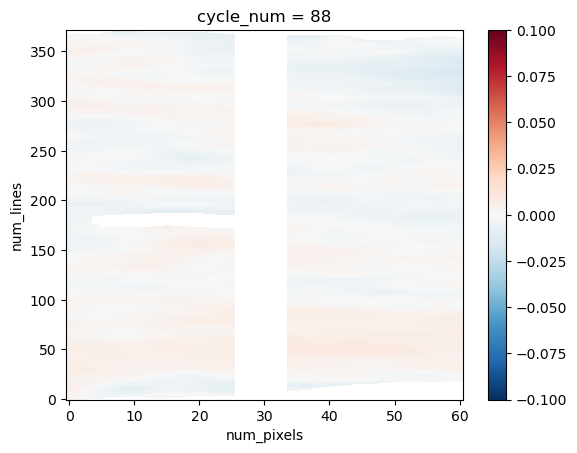

In [29]:
(tot-low3).isel(cycle_num=-10).plot(vmax=1e-1)

# Compute geostrophy
## Regridding approach

<xarray.DataArray (cycle_num: 96, YC: 389, XC: 155)> Size: 46MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, 

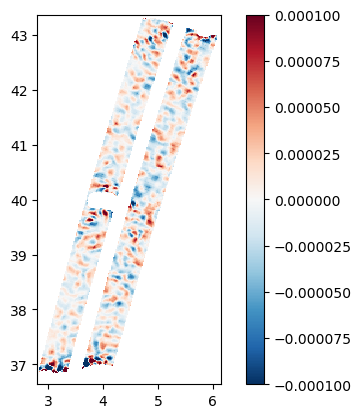

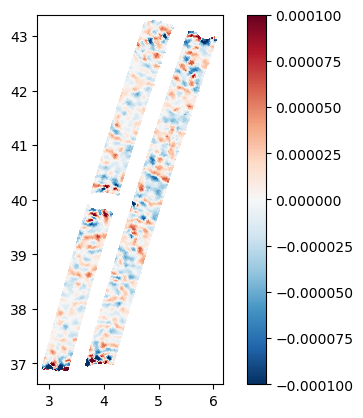

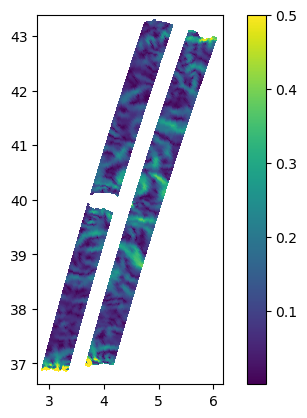

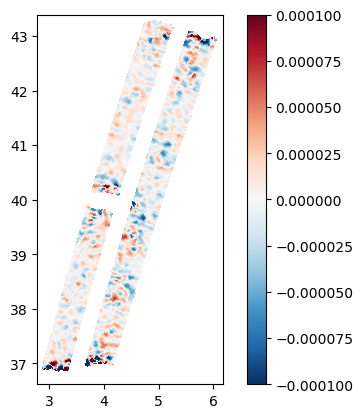

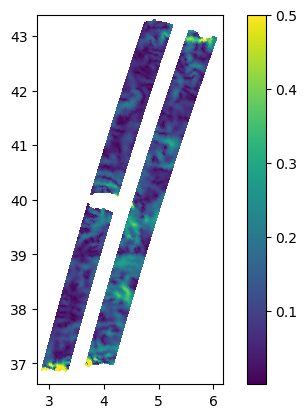

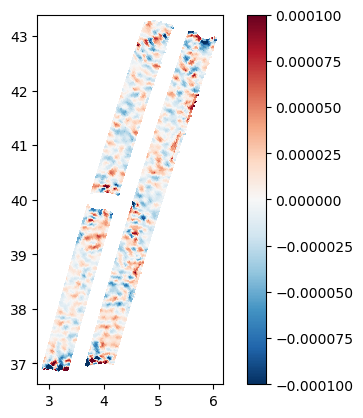

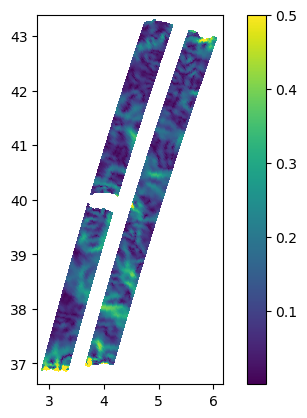

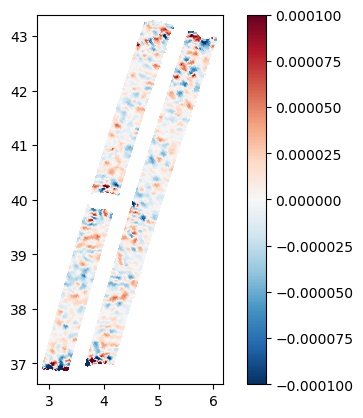

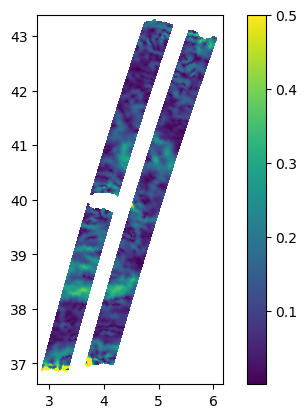

<xarray.Dataset> Size: 105MB
Dimensions:     (num_lines: 372, num_pixels: 61, cycle_num: 96)
Coordinates:
  * num_lines   (num_lines) int64 3kB 0 1 2 3 4 5 6 ... 366 367 368 369 370 371
  * num_pixels  (num_pixels) int64 488B 0 1 2 3 4 5 6 7 ... 54 55 56 57 58 59 60
  * cycle_num   (cycle_num) int64 768B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
    latitude    (num_lines, num_pixels) float64 182kB 36.86 36.86 ... 43.12
    longitude   (num_lines, num_pixels) float64 182kB 2.794 2.815 ... 6.158
    time        (cycle_num, num_lines, num_pixels) datetime64[ns] 17MB dask.array<chunksize=(2, 78, 31), meta=np.ndarray>
Data variables:
    vort        (cycle_num, num_lines, num_pixels) float64 17MB nan nan ... nan
    strain      (cycle_num, num_lines, num_pixels) float64 17MB nan nan ... nan
    vg          (cycle_num, num_lines, num_pixels) float64 17MB nan nan ... nan
    ug          (cycle_num, num_lines, num_pixels) float64 17MB nan nan ... nan
    ssha        (cycle_num, num_lines, num_

In [30]:
yy, xx = np.mgrid[low3.latitude.min(skipna=True).values:low3.latitude.max(skipna=True).values:np.abs(low3.latitude.diff('num_lines').min(skipna=True).values),
                  low3.longitude.min(skipna=True).values:low3.longitude.max(skipna=True).values:np.abs(low3.longitude.diff('num_pixels').min(skipna=True).values)
                 ]
lon = griddata((low3.latitude.values.flatten(),
                low3.longitude.values.flatten()
               ), 
               low3.longitude.values.flatten(), 
               (yy, xx), method='linear'
              )
lat = griddata((low3.latitude.values.flatten(),
                low3.longitude.values.flatten()
               ), 
               low3.latitude.values.flatten(), 
               (yy, xx), method='linear'
              )
for cc in ds3_gridded.cycle_num:
    ssh = griddata((low3.latitude.values.flatten(),
                    low3.longitude.values.flatten()
                   ), 
                   low3.sel(cycle_num=cc).values.flatten(), 
                   (yy, xx), method=meth
                  )
    if cc == ds3_gridded.cycle_num[0]:
        low3_gridded = xr.DataArray(ssh, dims=['YC','XC'], 
                           coords={'YC':np.mean(yy, axis=1),
                                   'XC':np.mean(xx, axis=0)}
                          )
    else:
        low3_gridded = xr.concat([low3_gridded, 
                          xr.DataArray(ssh, dims=['YC','XC'], 
                           coords={'YC':np.mean(yy, axis=1),
                                   'XC':np.mean(xx, axis=0)}
                          )
                         ], "cycle_num")
    del ssh
low3_gridded.coords['cycle_num'] = ds3_gridded.cycle_num
print(low3_gridded)
####################
xx, yy = np.meshgrid(low3_gridded.XC, low3_gridded.YC)
dx = gsw.distance(xx, yy, p=0, axis=-1)
dy = gsw.distance(xx, yy, p=0, axis=0)

cori = gsw.f(low3_gridded.YC)
coriY = gsw.f(low3_gridded.YC.rolling(YC=2).mean().dropna("YC"))

u = -(grav * low3_gridded.diff("YC")
      / coriY
      / dy)
v = (grav * low3_gridded.diff("XC")
     / cori 
     / dx)

u_x = u.diff("XC").values / (.5*(dx[1:] + dx[:-1]))
v_y = v.diff("YC").values / (.5*(dy[:,1:] + dy[:,:-1]))
u_x = .25*(u_x[...,:-1,:-1] + u_x[...,1:,:-1] + u_x[...,1:,1:] + u_x[...,:-1,1:])
v_y = .25*(v_y[...,:-1,:-1] + v_y[...,1:,:-1] + v_y[...,1:,1:] + v_y[...,:-1,1:])

u_y = (u.diff("YC").values / (.5*(dy[1:] + dy[:-1])))[...,:,1:-1]
v_x = (v.diff("XC").values / (.5*(dx[:,1:] + dx[:,:-1])))[:,1:-1]
        
vort = v_x - u_y

sn = u_x - v_y
ss = v_x + u_y
strain = np.sqrt(sn**2 + ss**2)

YG = (.5*(low3_gridded.YC[1:].data + low3_gridded.YC[:-1].data))
XG = (.5*(low3_gridded.XC[1:].data + low3_gridded.XC[:-1].data))

vor_g = xr.DataArray(vort, dims=["cycle_num",'YF','XF'], 
                     coords={"cycle_num":ds3_gridded.cycle_num.data,
                             'YF':low3_gridded.YC[1:-1].data, 
                             'XF':low3_gridded.XC[1:-1].data}
                    )
str_g = xr.DataArray(strain, dims=["cycle_num",'YF','XF'], 
                     coords={"cycle_num":ds3_gridded.cycle_num.data,
                             'YF':low3_gridded.YC[1:-1].data, 
                             'XF':low3_gridded.XC[1:-1].data}
                    )
u_g = xr.DataArray(u.data, dims=["cycle_num",'YG','XC'], 
                   coords={"cycle_num":ds3_gridded.cycle_num.data,
                           'YG':YG,
                           'XC':low3_gridded.XC.data}
                  )
v_g = xr.DataArray(v.data, dims=["cycle_num",'YC','XG'], 
                   coords={"cycle_num":ds3_gridded.cycle_num.data,
                           'YC':low3_gridded.YC.data,
                           'XG':XG}
                  )
                                             
fig, ax = plt.subplots()
im = ax.pcolormesh(low3_gridded.XC[1:-1].data, 
                   low3_gridded.YC[1:-1].data,
                   vor_g.isel(cycle_num=10),
                   rasterized=True,
                   cmap='RdBu_r', vmin=-1e-4, vmax=1e-4,
                  )
ax.set_aspect('equal')
fig.colorbar(im)
plt.show()

xf, yf = np.meshgrid(low3_gridded.XC[1:-1].data, 
                     low3_gridded.YC[1:-1].data)
xg, yc = np.meshgrid(XG, low3_gridded.YC.data)
xc, yg = np.meshgrid(low3_gridded.XC.data, YG)

for ii in ds3_gridded.cycle_num:
    
    _vorg = griddata((yf.flatten(), xf.flatten()), 
                   vor_g.sel(cycle_num=ii).values.flatten(), 
                   (low3.latitude.values,
                    low3.longitude.values), 
                   method=meth
                  )
    _strg = griddata((yf.flatten(), xf.flatten()), 
                   str_g.sel(cycle_num=ii).values.flatten(), 
                   (low3.latitude.values,
                    low3.longitude.values), 
                   method=meth
                  )
    
    _vg = griddata((yc.flatten(), xg.flatten()), 
                   v_g.sel(cycle_num=ii).values.flatten(), 
                   (low3.latitude.values,
                    low3.longitude.values), 
                   method=meth
                  )
    
    _ug = griddata((yg.flatten(), xc.flatten()), 
                   u_g.sel(cycle_num=ii).values.flatten(), 
                   (low3.latitude.values,
                    low3.longitude.values), 
                   method=meth
                  )

    maskh = low3.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                    ).to_masked_array().mask
    array = np.ma.masked_array(_vorg)
    # get only the valid values
    y1 = low3.latitude.values[~array.mask][0]
    x1 = low3.longitude.values[~array.mask][0]
    newarr = array[~array.mask][0]
    _vort = xr.DataArray(griddata((y1.flatten(),x1.flatten()),
                                 newarr.flatten(), 
                                 (low3.latitude.isel(num_pixels=slice(None,None)
                                            ).values,
                                  low3.longitude.isel(num_pixels=slice(None,None)
                                            ).values), 
                                 method=meth,
                                           # fill_value=0.
                                ), 
                        dims=low3.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                            ).dims,
                        coords=low3.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                            ).coords
                       ).where(~maskh)
    array = np.ma.masked_array(_strg)
    # get only the valid values
    y1 = low3.latitude.values[~array.mask][0]
    x1 = low3.longitude.values[~array.mask][0]
    newarr = array[~array.mask][0]
    _strain = xr.DataArray(griddata((y1.flatten(),x1.flatten()),
                                 newarr.flatten(), 
                                 (low3.latitude.isel(num_pixels=slice(None,None)
                                            ).values,
                                  low3.longitude.isel(num_pixels=slice(None,None)
                                            ).values), 
                                 method=meth,
                                           # fill_value=0.
                                ), 
                        dims=low3.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                            ).dims,
                        coords=low3.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                            ).coords
                       ).where(~maskh)
    array = np.ma.masked_array(_ug)
    # get only the valid values
    y1 = low3.latitude.values[~array.mask][0]
    x1 = low3.longitude.values[~array.mask][0]
    newarr = array[~array.mask][0]
    _ug = xr.DataArray(griddata((y1.flatten(),x1.flatten()),
                                 newarr.flatten(), 
                                 (low3.latitude.isel(num_pixels=slice(None,None)
                                            ).values,
                                  low3.longitude.isel(num_pixels=slice(None,None)
                                            ).values), 
                                 method=meth,
                                           # fill_value=0.
                                ), 
                        dims=low3.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                            ).dims,
                        coords=low3.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                            ).coords
                       ).where(~maskh)
    array = np.ma.masked_array(_vg)
    # get only the valid values
    y1 = low3.latitude.values[~array.mask][0]
    x1 = low3.longitude.values[~array.mask][0]
    newarr = array[~array.mask][0]
    _vg = xr.DataArray(griddata((y1.flatten(),x1.flatten()),
                                 newarr.flatten(), 
                                 (low3.latitude.isel(num_pixels=slice(None,None)
                                            ).values,
                                  low3.longitude.isel(num_pixels=slice(None,None)
                                            ).values), 
                                 method=meth,
                                           # fill_value=0.
                                ), 
                        dims=low3.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                            ).dims,
                        coords=low3.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                            ).coords
                       ).where(~maskh)

    # dsuv = _ug.to_dataset(name="ug").swap_dims({'num_pixels':'x', 'num_lines':'y'}
    #                                           ).reset_coords(drop=True)
    # dsuv["vg"] = _vg.swap_dims({'num_pixels':'x', 'num_lines':'y'}
    #                           ).reset_coords(drop=True)
    # dsuv.coords["y"] = ("y",range(len(dsuv.y)))
    # dsuv.coords["x"] = ("x",range(len(dsuv.x)))
    # if not dsuv.rio.crs:
    #     dsuv = dsuv.rio.write_crs("EPSG:4326")
    #     # dsH3 = dsH3.rio.write_crs("EPSG:3857")
    # if dsuv.ug.rio.nodata is None:
    #     dsuv["ug"] = dsuv.ug.rio.write_nodata(np.nan)
    # if dsuv.vg.rio.nodata is None:
    #     dsuv["vg"] = dsuv.vg.rio.write_nodata(np.nan)
    # _ug_extrap = dsuv.rio.interpolate_na().swap_dims({'x':'num_pixels', 
    #                                                  'y':'num_lines'}
    #                                                ).ug.where(~maskh)
    # _vg_extrap = dsuv.rio.interpolate_na().swap_dims({'x':'num_pixels', 
    #                                                  'y':'num_lines'}
    #                                                ).vg.where(~maskh)
    _ug[dict(num_pixels=slice(None,3))] = np.nan
    _ug[dict(num_pixels=slice(-2,None))] = np.nan
    _vg[dict(num_pixels=slice(None,3))] = np.nan
    _vg[dict(num_pixels=slice(-2,None))] = np.nan
    _ug[dict(num_pixels=[24,25,-27,-26,-25])] = np.nan
    _ug[dict(num_pixels=[24,25,-27,-26,-25])] = np.nan
    _vg[dict(num_pixels=[24,25,-27,-26,-25])] = np.nan
    _vg[dict(num_pixels=[24,25,-27,-26,-25])] = np.nan
    if ii == 0:
        vort = _vort
        strain = _strain
        ug = _ug
        vg = _vg
        ssha = low3.sel(cycle_num=ii)
    else:
        vort = xr.concat([vort, _vort], "cycle_num")
        strain = xr.concat([strain, _strain], "cycle_num")
        ug = xr.concat([ug, _ug], "cycle_num")
        vg = xr.concat([vg, _vg], "cycle_num")
        ssha = xr.concat([ssha, low3.sel(cycle_num=ii)
                         ], "cycle_num")

        if ii % 20 == 0:
            fig, ax = plt.subplots()
            im = ax.pcolor(low3.longitude.isel(num_pixels=slice(None,None)
                                             ), 
                           low3.latitude.isel(num_pixels=slice(None,None)
                                             ),
                           _vort,
                           rasterized=True,
                           cmap='RdBu_r', vmin=-1e-4, vmax=1e-4,
                          )
            ax.set_aspect('equal')
            fig.colorbar(im)
            plt.show()

            fig, ax = plt.subplots()
            im = ax.pcolor(low3.longitude.isel(num_pixels=slice(None,None)
                                             ), 
                           low3.latitude.isel(num_pixels=slice(None,None)
                                             ),
                           np.sqrt(_ug**2 
                                   + _vg**2
                                  ).where(~maskh),
                           rasterized=True, vmax=.5,
                          )
            ax.set_aspect('equal')
            fig.colorbar(im)
            plt.show()

    del _ug, _vg, _vort, _strain, _vorg, _strg
    ic += 1

dsave = vort.to_dataset(name="vort")
dsave["strain"] = strain
dsave["vg"] = vg
dsave["ug"] = ug
dsave["ssha"] = ssha

dsave = dsave.drop_vars("time")
dsave.coords["time"] = (("cycle_num","num_lines","num_pixels"),
                        H3.time.isel(num_pixels=slice(npx,-npx),
                                     num_lines=slice(nln,-nln-1)
                                    ).data
                       )
dsave.coords['cycle_num'] = ds3_gridded.cycle_num
# dsave.strain.isel(cycle_num=3).plot(vmax=3e-4, rasterized=True)
# plt.show()
print(dsave)

dsave.chunk({"cycle_num":1, "num_pixels":-1, "num_lines":-1}
           ).to_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/MedSea/Pass003/geos_Pass003_no-interp_%02dpoints.zarr' 
                             % (fscale)
                            ), mode='w')
dsave.close()

## [Tranchant approach](https://github.com/treden/SwotDiag.git)

In [29]:
import sys
sys.path.append('../')
from SwotDiag.diagnosis import *

In [30]:
params = dict(derivative = 'fit', # Derivative obtained by the fitting method instead of point difference
          n = 5, # 5*5 point kernels
          min_valid_points = 0.75, # Ratio of valid points to compute the derivative (e.g. 75% valid points are necessary to compute the derivatives, useful to avoid boundary effects)
          cyclostrophy = 'GW', # Cyclogeostrophic currents are computed using the wind-gradient balance
          avoid_negative = True, # Parameter that avoid negative values in the SQRT using the GW formulation (leading to invalid values in the solutions)
          second_derivative = 'dxdy', # The second derivative is obtained by point-difference the first derivative (obtained by surface fitting method), rather than from the surface curvature. I noticed that it reduces the noise. 
          kernel = 'circular', # can be circular or a square, the shape of the kernel

)

## Diagnostics from original SSH
for cc in low3.cycle_num:
    diag = compute_ocean_diagnostics_from_eta(low3.sel(cycle_num=cc), 
                                          low3.longitude, low3.latitude, **params
                                             )
    if cc == 0:
        dsave = xr.DataArray(diag["eta_fit"], dims=low3.sel(cycle_num=cc).dims,
                             coords=low3.sel(cycle_num=cc).coords
                            ).to_dataset(name='eta_fit')
        dsave["ug"] = xr.DataArray(diag["ug"], dims=low3.sel(cycle_num=cc).dims,
                             coords=low3.sel(cycle_num=cc).coords
                            )
        dsave["vg"] = xr.DataArray(diag["vg"], dims=low3.sel(cycle_num=cc).dims,
                             coords=low3.sel(cycle_num=cc).coords
                            )
        dsave["ucg"] = xr.DataArray(diag["ucg"], dims=low3.sel(cycle_num=cc).dims,
                             coords=low3.sel(cycle_num=cc).coords
                            )
        dsave["vcg"] = xr.DataArray(diag["vcg"], dims=low3.sel(cycle_num=cc).dims,
                             coords=low3.sel(cycle_num=cc).coords
                            )
        dsave["vort"] = xr.DataArray(diag["zeta"], dims=low3.sel(cycle_num=cc).dims,
                             coords=low3.sel(cycle_num=cc).coords
                            )
        dsave["OW"] = xr.DataArray(diag["OW"], dims=low3.sel(cycle_num=cc).dims,
                             coords=low3.sel(cycle_num=cc).coords
                            )
    else:
        tmp = xr.DataArray(diag["eta_fit"], dims=low3.sel(cycle_num=cc).dims,
                             coords=low3.sel(cycle_num=cc).coords
                            ).to_dataset(name='eta_fit')
        tmp["ug"] = xr.DataArray(diag["ug"], dims=low3.sel(cycle_num=cc).dims,
                             coords=low3.sel(cycle_num=cc).coords
                            )
        tmp["vg"] = xr.DataArray(diag["vg"], dims=low3.sel(cycle_num=cc).dims,
                             coords=low3.sel(cycle_num=cc).coords
                            )
        tmp["ucg"] = xr.DataArray(diag["ucg"], dims=low3.sel(cycle_num=cc).dims,
                             coords=low3.sel(cycle_num=cc).coords
                            )
        tmp["vcg"] = xr.DataArray(diag["vcg"], dims=low3.sel(cycle_num=cc).dims,
                             coords=low3.sel(cycle_num=cc).coords
                            )
        tmp["vort"] = xr.DataArray(diag["zeta"], dims=low3.sel(cycle_num=cc).dims,
                             coords=low3.sel(cycle_num=cc).coords
                            )
        tmp["OW"] = xr.DataArray(diag["OW"], dims=low3.sel(cycle_num=cc).dims,
                             coords=low3.sel(cycle_num=cc).coords
                            )
        dsave = xr.concat([dsave, tmp], "cycle_num")
        del tmp
dsave

Fitting derivatives on 22692 points (5*5 points kernel): 100%|█| 372/372 [00:04<00:00, 8
Fitting derivatives on 22692 points (5*5 points kernel): 100%|█| 372/372 [00:02<00:00, 1
Fitting derivatives on 22692 points (5*5 points kernel): 100%|█| 372/372 [00:02<00:00, 1
Fitting derivatives on 22692 points (5*5 points kernel): 100%|█| 372/372 [00:01<00:00, 1
Fitting derivatives on 22692 points (5*5 points kernel): 100%|█| 372/372 [00:01<00:00, 1
Fitting derivatives on 22692 points (5*5 points kernel): 100%|█| 372/372 [00:02<00:00, 1
Fitting derivatives on 22692 points (5*5 points kernel): 100%|█| 372/372 [00:02<00:00, 1
Fitting derivatives on 22692 points (5*5 points kernel): 100%|█| 372/372 [00:01<00:00, 1
Fitting derivatives on 22692 points (5*5 points kernel): 100%|█| 372/372 [00:02<00:00, 1
Fitting derivatives on 22692 points (5*5 points kernel): 100%|█| 372/372 [00:22<00:00, 1
Fitting derivatives on 22692 points (5*5 points kernel): 100%|█| 372/372 [00:03<00:00, 1
Fitting derivatives o

<xarray.Dataset> Size: 125MB
Dimensions:     (cycle_num: 98, num_lines: 372, num_pixels: 61)
Coordinates:
  * cycle_num   (cycle_num) int64 784B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
  * num_lines   (num_lines) int64 3kB 0 1 2 3 4 5 6 ... 366 367 368 369 370 371
  * num_pixels  (num_pixels) int64 488B 0 1 2 3 4 5 6 7 ... 54 55 56 57 58 59 60
    latitude    (num_lines, num_pixels) float64 182kB 36.86 36.86 ... 43.12
    longitude   (num_lines, num_pixels) float64 182kB 2.794 2.815 ... 6.158
    time        (num_lines, num_pixels) datetime64[ns] 182kB 2023-03-29T00:20...
Data variables:
    eta_fit     (cycle_num, num_lines, num_pixels) float64 18MB nan nan ... nan
    ug          (cycle_num, num_lines, num_pixels) float64 18MB nan nan ... nan
    vg          (cycle_num, num_lines, num_pixels) float64 18MB nan nan ... nan
    ucg         (cycle_num, num_lines, num_pixels) float64 18MB nan nan ... nan
    vcg         (cycle_num, num_lines, num_pixels) float64 18MB nan nan ... nan
    vort        (cycle_num, num_lines, num_pixels) float64 18MB nan nan ... nan
    OW          (cycle_num, num_lines, num_pixels) float64 18MB nan nan ... nan

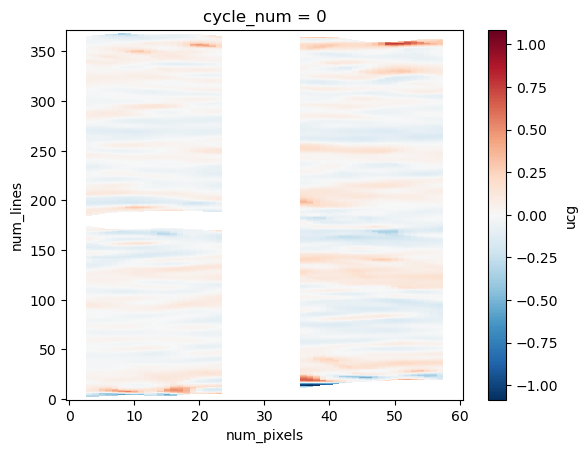

In [31]:
dsave.ucg.isel(cycle_num=0).plot(rasterized=True)
plt.show()
dsave.chunk({"cycle_num":1, "num_pixels":-1, "num_lines":-1}
           ).to_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/MedSea/Pass003/geos_Pass003_tranchant-afterDMD.zarr' 
                            ), mode='w')
dsave.close()

In [31]:
ds3l = xr.open_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/MedSea/Pass003/geos_Pass003_no-interp_%02dpoints.zarr' 
                             % (2)
                            )
                   )
ds3t = xr.open_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/MedSea/Pass003/geos_Pass003_tranchant-afterDMD.zarr' 
                            )
                   )
ds3l, ds3t

(<xarray.Dataset> Size: 105MB
 Dimensions:     (cycle_num: 96, num_lines: 372, num_pixels: 61)
 Coordinates:
   * cycle_num   (cycle_num) int64 768B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
   * num_lines   (num_lines) int64 3kB 0 1 2 3 4 5 6 ... 366 367 368 369 370 371
   * num_pixels  (num_pixels) int64 488B 0 1 2 3 4 5 6 7 ... 54 55 56 57 58 59 60
     latitude    (num_lines, num_pixels) float64 182kB dask.array<chunksize=(372, 61), meta=np.ndarray>
     longitude   (num_lines, num_pixels) float64 182kB dask.array<chunksize=(372, 61), meta=np.ndarray>
     time        (cycle_num, num_lines, num_pixels) datetime64[ns] 17MB dask.array<chunksize=(1, 372, 61), meta=np.ndarray>
 Data variables:
     ssha        (cycle_num, num_lines, num_pixels) float64 17MB dask.array<chunksize=(1, 372, 61), meta=np.ndarray>
     strain      (cycle_num, num_lines, num_pixels) float64 17MB dask.array<chunksize=(1, 372, 61), meta=np.ndarray>
     ug          (cycle_num, num_lines, num_pixels) float64 17MB

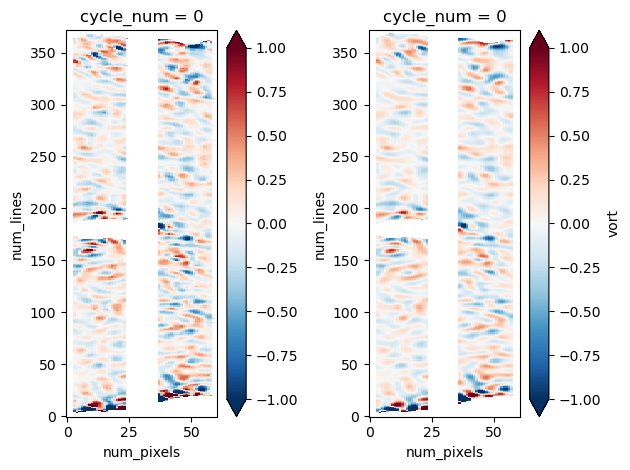

In [35]:
f = gsw.f(ds3l.vort.latitude)
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_tight_layout(True)
(ds3l.vort/f).sel(cycle_num=0).plot(ax=ax1, vmax=1, vmin=-1, 
                                cmap="RdBu_r", rasterized=True)
ds3t.vort.sel(cycle_num=0).plot(ax=ax2, vmax=1, vmin=-1, 
                                cmap="RdBu_r", rasterized=True)

2023-06-04T13:44:23.195678602


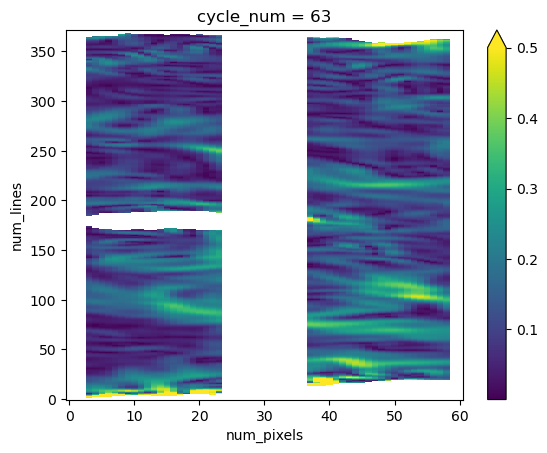

2023-06-05T13:35:01.120419088


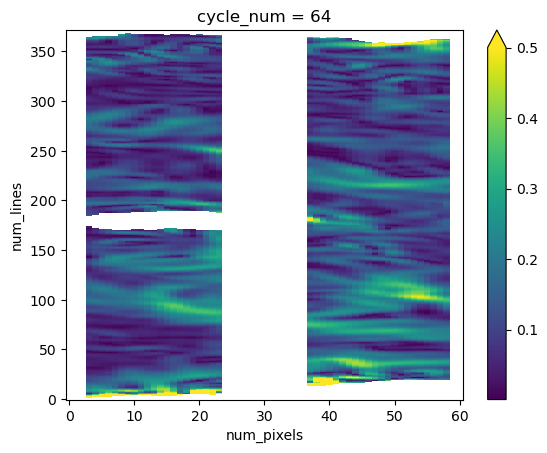

2023-06-06T13:25:39.016112684


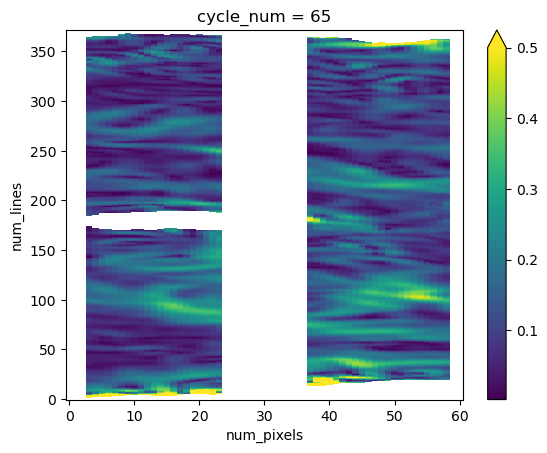

2023-06-07T13:16:16.882999916


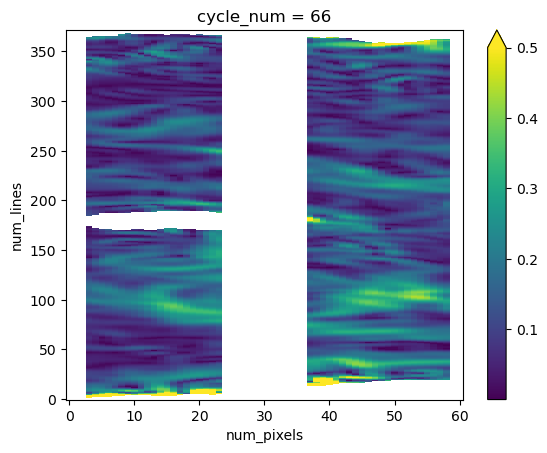

2023-06-08T13:06:54.715147548


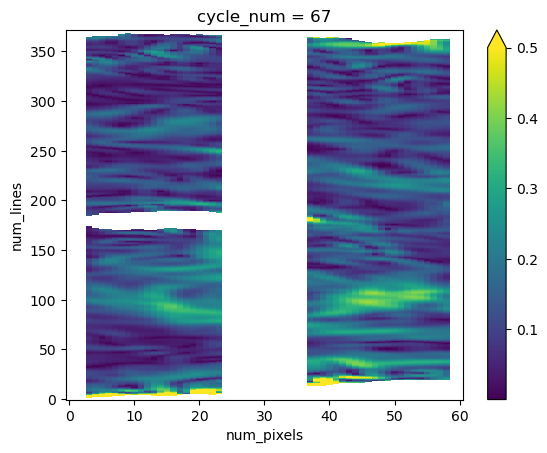

2023-06-09T12:57:32.510914126


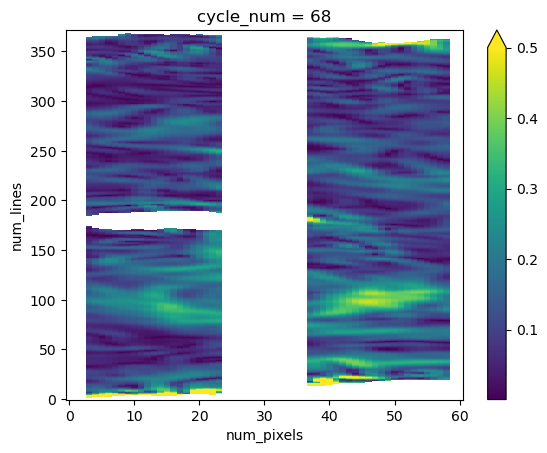

2023-06-10T12:48:10.273911496


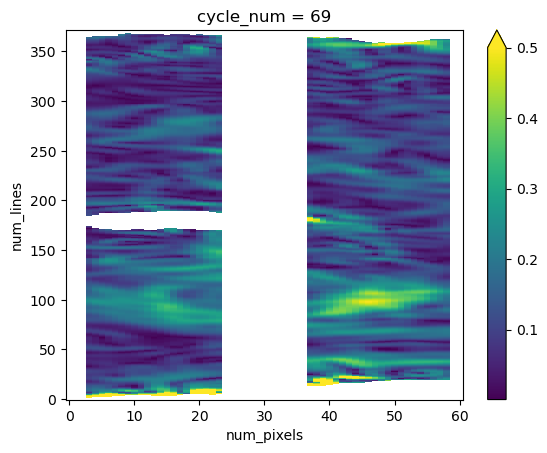

2023-06-11T12:38:48.006601104


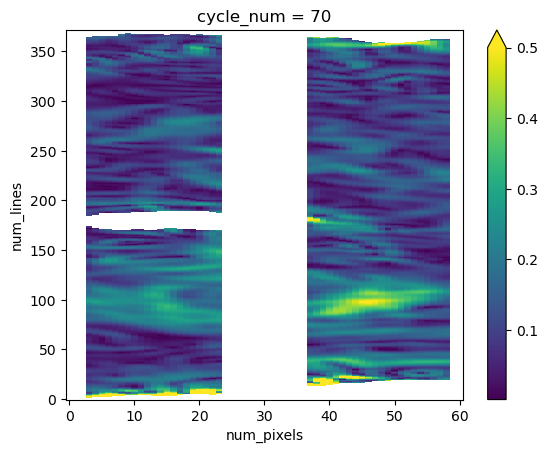

In [32]:
for cc in range(62,70):
    print(ds3l.time.isel(cycle_num=cc).mean().values)
    np.sqrt(ds3l.ug.isel(cycle_num=cc)**2 
     + ds3l.vg.isel(cycle_num=cc)**2).plot(rasterized=True, vmax=.5)
    plt.show()
    # ds3l.vg.isel(cycle_num=cc).plot(rasterized=True)
    # plt.show()

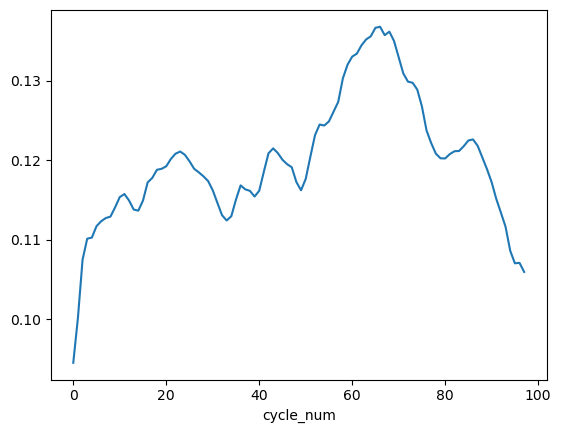

In [44]:
np.sqrt(ds3l.ug**2 + ds3l.vg**2
       ).mean(["num_lines","num_pixels"], skipna=True
             ).plot()